# Grid Search Results Analysis

This notebook aggregates grid search analysis reports and generates metric scatter plots.

In [1]:
"""Aggregate grid search analysis reports and generate metric scatter plots."""

from __future__ import annotations
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence, Tuple

import argparse
import json
import math
import statistics
from collections import defaultdict

import numpy as np

import matplotlib
import matplotlib.pyplot as plt  # noqa: E402
from matplotlib.colors import LinearSegmentedColormap, Normalize, to_rgb  # noqa: E402
from matplotlib.lines import Line2D  # noqa: E402
from matplotlib.patches import Ellipse, Patch  # noqa: E402

%matplotlib inline


In [2]:
DEFAULT_METRICS: Sequence[str] = (
    "psnr_mean",
    "ssim_mean",
    "vmaf_mean",
    "lpips_mean",
    "fvmd",
)

EXCLUDED_METRIC_KEYWORDS: Sequence[str] = ("execution", "parameter")

LOG_SCALE_METRICS: Sequence[str] = ("fvmd",)

MIN_LOG_VALUE: float = 1e-6

TIME_COMPLEXITY_FIGURE_NAME = "execution_throughput.png"
TIME_COMPLEXITY_BY_RES_FIGURE_NAME = "execution_throughput_by_resolution.png"
METRIC_HEXBIN_FIGURE_NAME = "metric_hexbin.png"
METRIC_KDE_FIGURE_NAME = "metric_kde.png"
METRIC_VIOLIN_FIGURE_NAME = "metric_violin_foreground.png"
METRIC_ALPHA_SCATTER_FIGURE_NAME = "metric_alpha_scatter.png"
METRIC_STACKED_BAR_FIGURE_NAME = "metric_stacked_bar.png"
PARAM_CORRELATION_FIGURE_NAME = "parameter_correlation.png"
PARAM_CORRELATION_ELVIS_FIGURE_NAME = "parameter_correlation_elvis.png"
PARAM_CORRELATION_PRESLEY_FIGURE_NAME = "parameter_correlation_presley.png"

PARAMETER_KEYS_FOR_CORRELATION: Sequence[str] = (
    "reference_video",
    "experiment_dir",
    "width",
    "height",
    "block_size",
    "shrink_amount",
    "enable_fvmd",
    "quality_factor",
    "removability_alpha",
    "removability_smoothing_beta",
    "downsample_strength_target_bitrate",
    "gaussian_strength_target_bitrate",
    # ELVIS restoration/inpainting
    "propainter_resize_ratio",
    "propainter_ref_stride",
    "propainter_neighbor_length",
    "propainter_subvideo_length",
    "propainter_mask_dilation",
    "propainter_raft_iter",
    "propainter_fp16",
    "propainter_parallel_chunk_length",
    "propainter_chunk_overlap",
    "e2fgvi_ref_stride",
    "e2fgvi_neighbor_stride",
    "e2fgvi_num_ref",
    "e2fgvi_mask_dilation",
    # PRESLEY restoration/super-resolution
    "realesrgan_denoise_strength",
    "realesrgan_tile",
    "realesrgan_tile_pad",
    "realesrgan_pre_pad",
    "realesrgan_parallel_chunk_length",
    "realesrgan_per_device_workers",
    "instantir_cfg",
    "instantir_creative_start",
    "instantir_preview_start",
    "instantir_batch_size",
    "analysis_sample_frames",
    "generate_opencv_benchmarks",
    "metric_stride",
    "fvmd_stride",
    "fvmd_max_frames",
    "fvmd_processes",
    "fvmd_early_stop_delta",
    "fvmd_early_stop_window",
    "vmaf_stride",
)

KDE_METRIC_KEY: str = "vmaf_mean"
KDE_GROUP_KEY: str = "video_name"

TASK_GROUP_ORDER: Sequence[str] = (
    "Preprocessing",
    "Removability scores",
    "Baseline",
    "ELVIS",
    "PRESLEY",
    "Performance evaluation",
)

OTHER_TASK_GROUP_LABEL = "zzz_other"




In [3]:
def _classify_task_group(task_name: str) -> str:
    """Map a raw task label to a conceptual group for ordering/filtering."""
    name = str(task_name or "").lower()
    if any(keyword in name for keyword in ("decode", "resize", "downsample", "shrink", "preprocess", "denoise", "mask")):
        return "Preprocessing"
    if any(keyword in name for keyword in ("removability", "alpha", "smoothing", "fvmd")):
        return "Removability scores"
    if any(keyword in name for keyword in ("baseline", "avc", "hevc", "encode", "bitrate")):
        return "Baseline"
    if any(keyword in name for keyword in ("propainter", "e2fgvi", "inpaint", "elvis")):
        return "ELVIS"
    if any(keyword in name for keyword in ("realesrgan", "instantir", "presley", "superres", "sr")):
        return "PRESLEY"
    if any(keyword in name for keyword in ("metric", "vmaf", "psnr", "ssim", "lpips", "benchmark", "performance", "evaluation", "throughput")):
        return "Performance evaluation"
    return OTHER_TASK_GROUP_LABEL



def _is_performance_evaluation_task(task_name: str) -> bool:
    return _classify_task_group(task_name) == "Performance evaluation"



def _estimate_frame_count(payload: Dict[str, Any]) -> Optional[float]:
    length = payload.get("video_length_seconds")
    framerate = payload.get("video_framerate")
    try:
        length_val = float(length)
        framerate_val = float(framerate)
    except (TypeError, ValueError):
        return None
    if length_val <= 0 or framerate_val <= 0:
        return None
    return length_val * framerate_val



def _collect_execution_samples(
    samples: Dict[str, List[float]],
    times: Dict[str, Any],
    frame_count: Optional[float],
) -> None:
    if not times or frame_count is None or frame_count <= 0:
        return

    for raw_task, seconds in times.items():
        task = raw_task
        try:
            duration = float(seconds)
        except (TypeError, ValueError):
            continue
        if duration <= 0:
            continue
        fps = frame_count / duration
        samples.setdefault(task, []).append(fps)



def _collect_execution_samples_by_res(
    samples: Dict[str, Dict[str, List[float]]],
    times: Dict[str, Any],
    frame_count: Optional[float],
    resolution_label: str,
) -> None:
    if not times or frame_count is None or frame_count <= 0:
        return
    label = str(resolution_label or "unknown")
    for raw_task, seconds in times.items():
        task = raw_task
        try:
            duration = float(seconds)
        except (TypeError, ValueError):
            continue
        if duration <= 0:
            continue
        fps = frame_count / duration
        samples.setdefault(task, {}).setdefault(label, []).append(fps)



def _extract_resolution_label(payload: Dict[str, Any]) -> str:
    """Try to extract a WxH resolution label from the analysis payload.
    Priority: payload['video_resolution'] -> parameters.config/derived width/height -> payload width/height -> 'unknown'.
    """
    try:
        vr = payload.get("video_resolution")
        if isinstance(vr, (list, tuple)) and len(vr) == 2:
            w, h = vr
            w_i = int(float(w)) if w is not None else None
            h_i = int(float(h)) if h is not None else None
            if w_i and h_i:
                return f"{w_i}x{h_i}"
        elif isinstance(vr, str) and "x" in vr:
            parts = vr.lower().split("x")
            if len(parts) == 2:
                return f"{int(float(parts[0]))}x{int(float(parts[1]))}"
    except Exception:
        pass

    # Search parameters blocks
    try:
        params = payload.get("parameters") if isinstance(payload.get("parameters"), dict) else {}
        cfg = params.get("config") if isinstance(params.get("config"), dict) else {}
        drv = params.get("derived") if isinstance(params.get("derived"), dict) else {}
        for source in (cfg, drv, payload):
            try:
                w = source.get("width")
                h = source.get("height")
                if w is not None and h is not None:
                    wi = int(float(w))
                    hi = int(float(h))
                    if wi > 0 and hi > 0:
                        return f"{wi}x{hi}"
            except Exception:
                continue
    except Exception:
        pass

    return "unknown"



def _metric_root(metric: str) -> str:
    return metric.split("_", 1)[0].lower()



def _derive_video_name(rel_parent: Path) -> str:
    candidate = rel_parent.parts[0] if rel_parent.parts else str(rel_parent)
    text = str(candidate)
    if "reference_video--" in text:
        text = text.split("reference_video--", 1)[1]
    if "avc_encoded-" in text:
        text = text.split("avc_encoded-", 1)[1]
    text = text.replace("__", "_")
    if text.endswith("pmp4"):
        text = text[: -len("pmp4")]
    elif text.endswith(".mp4"):
        text = text[: -len(".mp4")]
    text = text.strip("-_ ")
    if not text:
        text = str(candidate)
    return text or "unknown"


def _shorten_video_name(video_name: str) -> str:
    """
    Return a short video label from a potentially long path or name.
    Uses the path basename then takes the last /-separated token (and strips extension).
    Example: "/home/.../avc_encoded-walking.mp4" -> "avc_encoded-walking.mp4" -> avc_encoded-walking
    """
    try:
        base = Path(str(video_name)).name
    except Exception:
        base = str(video_name)
    # remove common extensions
    for ext in (".pmp4", ".mp4", ".mov", ".mkv"):
        if base.endswith(ext):
            base = base[: -len(ext)]
            break
    # take last dash-separated token
    short = base.split("/")[-1]
    # remove extension
    short = short.rsplit(".", 1)[0]
    return short or base



def _extract_foreground_background_arrays(
    entries: Sequence[Dict[str, Any]]
) -> Tuple[np.ndarray, np.ndarray]:
    background_values: List[float] = []
    foreground_values: List[float] = []
    for entry in entries:
        bg = entry.get("background")
        fg = entry.get("foreground")
        if bg is None or fg is None:
            continue
        if isinstance(bg, (list, tuple)):
            bg = bg[0] if bg else None
        if isinstance(fg, (list, tuple)):
            fg = fg[0] if fg else None
        try:
            bg_val = float(bg)
            fg_val = float(fg)
        except (TypeError, ValueError):
            continue
        background_values.append(bg_val)
        foreground_values.append(fg_val)
    return np.asarray(background_values, dtype=float), np.asarray(foreground_values, dtype=float)



def _find_analysis_reports(root: Path) -> List[Path]:
    return sorted(root.rglob("analysis_results.json"))



def _load_json(path: Path) -> Dict:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)



def _prepare_data(
    report_paths: Sequence[Path],
    metrics: Sequence[str],
    root: Path,
) -> Tuple[Dict[str, List[Dict[str, Any]]], List[str], Dict[str, List[float]], Dict[str, Dict[str, List[float]]]]:
    metric_points: Dict[str, List[Dict[str, Any]]] = {metric: [] for metric in metrics}
    approaches: List[str] = []
    execution_samples: Dict[str, List[float]] = {}
    execution_samples_by_res: Dict[str, Dict[str, List[float]]] = {}

    for path in report_paths:
        try:
            payload = _load_json(path)
        except (json.JSONDecodeError, OSError) as exc:
            print(f"Skipping {path}: failed to read JSON ({exc}).")
            continue

        try:
            rel_parent = path.parent.relative_to(root)
        except ValueError:
            rel_parent = path.parent

        # prefer an explicit video_name inside the summary, otherwise derive from path
        try:
            payload_video_name = payload.get("video_name")
        except Exception:
            payload_video_name = None

        if payload_video_name:
            # take last path component if payload contains a full path
            try:
                video_name = str(payload_video_name).split("/")[-1]
            except Exception:
                video_name = str(payload_video_name)
        else:
            video_name = _derive_video_name(rel_parent)
        frame_count = _estimate_frame_count(payload)
        times_entry = payload.get("execution_times_seconds")
        if isinstance(times_entry, dict):
            _collect_execution_samples(execution_samples, times_entry, frame_count)
            resolution_label = _extract_resolution_label(payload)
            _collect_execution_samples_by_res(execution_samples_by_res, times_entry, frame_count, resolution_label)

        for experiment_name, experiment_data in payload.items():
            if experiment_name == "execution_times_seconds":
                continue

            if not isinstance(experiment_data, dict):
                continue

            if "foreground" not in experiment_data or "background" not in experiment_data:
                continue
            foreground = experiment_data.get("foreground", {})
            background = experiment_data.get("background", {})

            added = False

            for metric in metrics:
                fg_value = foreground.get(metric)
                bg_value = background.get(metric)
                if fg_value is None or bg_value is None:
                    continue
                if metric.endswith("_mean"):
                    std_key = metric.replace("_mean", "_std")
                else:
                    std_key = f"{metric}_std"

                fg_std = foreground.get(std_key)
                bg_std = background.get(std_key)

                metric_points.setdefault(metric, []).append(
                    {
                        "foreground": float(fg_value),
                        "background": float(bg_value),
                        "foreground_std": float(fg_std) if fg_std is not None else None,
                        "background_std": float(bg_std) if bg_std is not None else None,
                        "experiment": experiment_name,
                        "approach": experiment_name,
                        "source": str(rel_parent),
                        "video_name": video_name,
                    }
                )
                added = True

            if added and experiment_name not in approaches:
                approaches.append(experiment_name)

    return metric_points, approaches, execution_samples, execution_samples_by_res



def _plot_parameter_correlation(
    report_paths: Sequence[Path],
    metrics: Sequence[str],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    """
    Compute Pearson correlation between each parameter (rows) and each metric (columns).
    The data is gathered from the same analysis JSON files used by the other plots.
    """
    rows: List[Dict[str, Any]] = []

    for path in report_paths:
        try:
            payload = _load_json(path)
        except Exception:
            continue

        if isinstance(payload, dict):
            # experiments are top-level keys -> each exp_data may contain overrides and metrics
            for exp_name, exp_data in payload.items():
                if not isinstance(exp_data, dict):
                    continue
                # collect parameter values
                overrides = exp_data.get("overrides") if isinstance(exp_data.get("overrides"), dict) else payload.get("overrides") if isinstance(payload.get("overrides"), dict) else {}
                param_vals: Dict[str, Any] = {}
                for key in PARAMETER_KEYS_FOR_CORRELATION:
                    val = overrides.get(key) if overrides and key in overrides else exp_data.get(key)
                    param_vals[key] = val

                # collect metric values (prefer foreground values)
                fg = exp_data.get("foreground") if isinstance(exp_data.get("foreground"), dict) else {}
                bg = exp_data.get("background") if isinstance(exp_data.get("background"), dict) else {}
                metric_vals: Dict[str, Any] = {}
                any_metric = False
                for metric in metrics:
                    mv = fg.get(metric, None)
                    if mv is None:
                        mv = bg.get(metric, None)
                    # if list/tuple take first
                    if isinstance(mv, (list, tuple)):
                        mv = mv[0] if mv else None
                    metric_vals[metric] = mv
                    if mv is not None:
                        any_metric = True

                if any_metric and any(v is not None for v in param_vals.values()):
                    rows.append({"params": param_vals, "metrics": metric_vals})

        elif isinstance(payload, list):
            # runs_summary-style list
            for entry in payload:
                if not isinstance(entry, dict):
                    continue
                overrides = entry.get("overrides") or {}
                param_vals = {key: overrides.get(key) for key in PARAMETER_KEYS_FOR_CORRELATION}
                metric_vals = {}
                fg = entry.get("foreground") or {}
                bg = entry.get("background") or {}
                any_metric = False
                for metric in metrics:
                    mv = fg.get(metric) if isinstance(fg, dict) else None
                    if mv is None:
                        mv = bg.get(metric) if isinstance(bg, dict) else None
                    if isinstance(mv, (list, tuple)):
                        mv = mv[0] if mv else None
                    metric_vals[metric] = mv
                    if mv is not None:
                        any_metric = True
                if any_metric and any(v is not None for v in param_vals.values()):
                    rows.append({"params": param_vals, "metrics": metric_vals})

    if not rows:
        print("No parameter/metric rows found for correlation; skipping parameter correlation plot.")
        return

    # For each parameter and metric pair, collect paired numeric samples and compute Pearson r
    param_keys = list(PARAMETER_KEYS_FOR_CORRELATION)
    metric_keys = list(metrics)
    corr_matrix = np.full((len(param_keys), len(metric_keys)), np.nan, dtype=float)

    for i, pkey in enumerate(param_keys):
        for j, mkey in enumerate(metric_keys):
            xs: List[float] = []
            ys: List[float] = []
            for r in rows:
                pval = r["params"].get(pkey)
                mval = r["metrics"].get(mkey)
                try:
                    if isinstance(pval, bool):
                        xv = float(int(pval))
                    else:
                        xv = float(pval)
                except Exception:
                    continue
                try:
                    yv = float(mval)
                except Exception:
                    continue
                if not (math.isfinite(xv) and math.isfinite(yv)):
                    continue
                xs.append(xv)
                ys.append(yv)

            if len(xs) >= 2 and len(set(xs)) > 1 and len(set(ys)) > 1:
                try:
                    corr_val = float(np.corrcoef(np.array(xs), np.array(ys))[0, 1])
                except Exception:
                    corr_val = np.nan
                corr_matrix[i, j] = corr_val

    # Plot heatmap (parameters on y, metrics on x)
    fig_w = max(6.0, 0.5 * len(metric_keys))
    fig_h = max(6.0, 0.35 * len(param_keys))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(corr_matrix, cmap="coolwarm", vmin=-1.0, vmax=1.0, aspect="auto")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Pearson r")

    ax.set_xticks(range(len(metric_keys)))
    ax.set_xticklabels([m.replace("_", " ") for m in metric_keys], rotation=45, ha="right")
    ax.set_yticks(range(len(param_keys)))
    ax.set_yticklabels(param_keys)

    # annotate
    for i in range(len(param_keys)):
        for j in range(len(metric_keys)):
            val = corr_matrix[i, j]
            text = "" if np.isnan(val) else f"{val:.2f}"
            ax.text(j, i, text, ha="center", va="center", color="black", fontsize=8)

    ax.set_title("Parameter vs Metric Pearson Correlation")
    fig.tight_layout()

#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi, bbox_inches="tight")
#     print(f"Saved parameter correlation plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    



def _build_data_matrices(
    report_paths: Sequence[Path],
    metrics: Sequence[str],
) -> Tuple[List[str], List[str], List[str], np.ndarray, np.ndarray]:
    """
    Build numeric matrices from analysis JSONs.
    Returns (experiments, param_keys, metric_keys, params_array, metrics_array)
    where params_array shape = (N_experiments, N_params) and metrics_array shape = (N_experiments, N_metrics).
    Missing or non-numeric values are set to NaN.
    """
    param_keys = list(PARAMETER_KEYS_FOR_CORRELATION)[:]
    # ensure video length/framerate and bitrate are included
    extra_params = ["video_length_seconds", "video_framerate", "target_bitrate_bps"]
    for p in extra_params:
        if p not in param_keys:
            param_keys.append(p)

    metric_keys = list(metrics)

    rows: List[Dict[str, Any]] = []
    experiment_ids: List[str] = []

    for path in report_paths:
        try:
            payload = _load_json(path)
        except Exception:
            continue

        # payload can be dict of experiments
        if isinstance(payload, dict):
            # common video-level params
            vid_len = payload.get("video_length_seconds")
            vid_fr = payload.get("video_framerate")

            parameters_block = payload.get("parameters") if isinstance(payload.get("parameters"), dict) else {}
            config_params = parameters_block.get("config") if isinstance(parameters_block.get("config"), dict) else {}
            derived_params = parameters_block.get("derived") if isinstance(parameters_block.get("derived"), dict) else {}
            functions_params = parameters_block.get("functions") if isinstance(parameters_block.get("functions"), dict) else {}
            function_param_dicts: List[Dict[str, Any]] = []
            for func_payload in functions_params.values():
                if isinstance(func_payload, dict):
                    function_param_dicts.append(func_payload)

            for exp_name, exp_data in payload.items():
                if exp_name == "execution_times_seconds":
                    continue
                if not isinstance(exp_data, dict):
                    continue
                if "foreground" not in exp_data and "background" not in exp_data:
                    continue

                # experiment id
                exp_id = f"{path.parent}/{exp_name}"
                experiment_ids.append(exp_id)

                overrides = exp_data.get("overrides") if isinstance(exp_data.get("overrides"), dict) else {}
                if not overrides and isinstance(payload.get("overrides"), dict):
                    overrides = payload.get("overrides") or {}

                candidate_sources: List[Dict[str, Any]] = []
                if overrides:
                    candidate_sources.append(overrides)
                candidate_sources.append(exp_data)
                candidate_sources.append(payload)
                if config_params:
                    candidate_sources.append(config_params)
                if derived_params:
                    candidate_sources.append(derived_params)
                if parameters_block:
                    candidate_sources.append(parameters_block)

                param_row: Dict[str, Any] = {}
                for pk in param_keys:
                    if pk in ("video_length_seconds", "video_framerate"):
                        param_row[pk] = vid_len if pk == "video_length_seconds" else vid_fr
                        continue

                    value: Any = None
                    for source in candidate_sources:
                        if not isinstance(source, dict):
                            continue
                        if pk in source and source[pk] is not None:
                            value = source[pk]
                            break

                    # try common nested places for bitrate
                    if value is None and pk == "target_bitrate_bps":
                        video_meta = payload.get("video_metadata") if isinstance(payload.get("video_metadata"), dict) else {}
                        if isinstance(video_meta, dict):
                            value = video_meta.get("target_bitrate_bps")

                    if value is None:
                        for func_payload in function_param_dicts:
                            if pk in func_payload and func_payload[pk] is not None:
                                value = func_payload[pk]
                                break

                    param_row[pk] = value

                # collect metric values (prefer foreground then background)
                fg = exp_data.get("foreground") if isinstance(exp_data.get("foreground"), dict) else {}
                bg = exp_data.get("background") if isinstance(exp_data.get("background"), dict) else {}
                metric_row: Dict[str, Any] = {}
                for mk in metric_keys:
                    mv = fg.get(mk, None) if isinstance(fg, dict) else None
                    if mv is None:
                        mv = bg.get(mk, None) if isinstance(bg, dict) else None
                    if isinstance(mv, (list, tuple)):
                        mv = mv[0] if mv else None
                    metric_row[mk] = mv

                rows.append({"params": param_row, "metrics": metric_row})

        elif isinstance(payload, list):
            # runs_summary style
            for entry in payload:
                if not isinstance(entry, dict):
                    continue
                if "foreground" not in entry and "background" not in entry:
                    continue
                exp_id = f"{path.parent}/{entry.get('experiment','entry')}"
                experiment_ids.append(exp_id)

                overrides = entry.get("overrides") or {}
                param_row = {pk: overrides.get(pk) for pk in param_keys}
                param_row["video_length_seconds"] = entry.get("video_length_seconds")
                param_row["video_framerate"] = entry.get("video_framerate")
                fg = entry.get("foreground") or {}
                bg = entry.get("background") or {}
                metric_row = {}
                for mk in metric_keys:
                    mv = fg.get(mk) if isinstance(fg, dict) else None
                    if mv is None:
                        mv = bg.get(mk) if isinstance(bg, dict) else None
                    if isinstance(mv, (list, tuple)):
                        mv = mv[0] if mv else None
                    metric_row[mk] = mv
                rows.append({"params": param_row, "metrics": metric_row})

    N = len(rows)
    P = len(param_keys)
    M = len(metric_keys)
    if N == 0:
        return experiment_ids, param_keys, metric_keys, np.empty((0, P)), np.empty((0, M))

    params_arr = np.full((N, P), np.nan, dtype=float)
    metrics_arr = np.full((N, M), np.nan, dtype=float)

    for i, r in enumerate(rows):
        for j, pk in enumerate(param_keys):
            v = r["params"].get(pk)
            if isinstance(v, (list, tuple)):
                numeric_items = [item for item in v if isinstance(item, (int, float))]
                if numeric_items:
                    v = numeric_items[0]
                elif len(v) == 1:
                    try:
                        v = float(v[0])
                    except Exception:
                        v = len(v)
                else:
                    try:
                        v = float(v[0])
                    except Exception:
                        v = len(v)
            try:
                if isinstance(v, bool):
                    params_arr[i, j] = float(int(v))
                elif v is None:
                    params_arr[i, j] = np.nan
                else:
                    params_arr[i, j] = float(v)
            except Exception:
                params_arr[i, j] = np.nan

        for k, mk in enumerate(metric_keys):
            mv = r["metrics"].get(mk)
            if isinstance(mv, (list, tuple)):
                numeric_items = [item for item in mv if isinstance(item, (int, float))]
                if numeric_items:
                    mv = numeric_items[0]
                elif len(mv) == 1:
                    try:
                        mv = float(mv[0])
                    except Exception:
                        mv = len(mv)
                else:
                    try:
                        mv = float(mv[0])
                    except Exception:
                        mv = len(mv)
            try:
                metrics_arr[i, k] = float(mv) if mv is not None else np.nan
            except Exception:
                metrics_arr[i, k] = np.nan

    return experiment_ids, param_keys, metric_keys, params_arr, metrics_arr



def _select_param_subset(
    param_keys: Sequence[str],
    params_arr: np.ndarray,
    group: str,
) -> Tuple[List[str], np.ndarray]:
    """Return filtered (param_keys, params_arr) for the requested group.

    group: 'elvis' or 'presley'
    - Common parameters: block_size, video_length_seconds, target_bitrate_bps
    - ELVIS-specific: shrink_amount, propainter_*, e2fgvi_*
    - PRESLEY-specific: realesrgan_*, instantir_*
    Exclude: width, height, enable_fvmd, analysis_sample_frames, generate_opencv_benchmarks
    """
    banned = {
        "width",
        "height",
        "enable_fvmd",
        "analysis_sample_frames",
        "generate_opencv_benchmarks",
    }
    common = {"block_size", "video_length_seconds", "target_bitrate_bps"}

    def allowed(key: str) -> bool:
        if key in banned:
            return False
        if key in common:
            return True
        if group == "elvis":
            return key == "shrink_amount" or key.startswith("propainter_") or key.startswith("e2fgvi_")
        if group == "presley":
            return key.startswith("realesrgan_") or key.startswith("instantir_")
        return False

    indices: List[int] = [i for i, k in enumerate(param_keys) if allowed(k)]
    filtered_keys = [param_keys[i] for i in indices]
    filtered_params = params_arr[:, indices] if params_arr.size and indices else np.empty((params_arr.shape[0] if params_arr.ndim == 2 else 0, 0))
    return filtered_keys, filtered_params



def _plot_execution_throughput(
    execution_throughput: Dict[str, List[float]],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    if not execution_throughput:
        print("No execution throughput data available; skipping throughput plot.")
        return

    aggregated = [
        (
            task,
            statistics.fmean(samples) if samples else 0.0,
            statistics.pstdev(samples) if len(samples) > 1 else 0.0,
        )
        for task, samples in execution_throughput.items()
        if samples
    ]

    if not aggregated:
        print("No valid execution throughput samples collected; skipping throughput plot.")
        return

    aggregated.sort(key=lambda item: item[1], reverse=True)
    tasks = [item[0] for item in aggregated]
    means = [item[1] for item in aggregated]
    stds = [item[2] for item in aggregated]

    samples_by_task = [execution_throughput.get(task, []) for task in tasks]
    positive_samples = all(sample > 0 for samples in samples_by_task for sample in samples)

    sanitized_samples = [
        [max(sample, MIN_LOG_VALUE) for sample in samples] if positive_samples else list(samples)
        for samples in samples_by_task
    ]

    flattened_samples = [value for row in sanitized_samples for value in row]
    positive_flattened = [value for value in flattened_samples if value > 0]
    global_min = min(flattened_samples) if flattened_samples else 0.0
    global_max = max(flattened_samples) if flattened_samples else 0.0

    use_log_scale = all(mean > 0 for mean in means) and positive_samples

    fig_height = max(4.0, 0.45 * len(tasks) + 1.5)
    fig_width = 9.5
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    y_positions = list(range(len(tasks)))

    palette = LinearSegmentedColormap.from_list(
        "execution_fps_palette",
        ["black", "red", "yellow", "green", "blue"],
    )
    if means:
        min_mean = min(means)
        max_mean = max(means)
        if math.isclose(max_mean, min_mean):
            colors = [palette(0.8) for _ in means]
        else:
            norm = Normalize(vmin=min_mean, vmax=max_mean)
            colors = [palette(norm(value)) for value in means]
    else:
        colors = []

    boxplot = ax.boxplot(
        sanitized_samples,
        vert=False,
        patch_artist=True,
        showfliers=True,
        positions=y_positions,
    )

    for patch, color in zip(boxplot["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")
        patch.set_alpha(0.6)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(tasks)
    ax.invert_yaxis()

    boundaries = np.arange(len(tasks) + 1) - 0.5
    for boundary in boundaries:
        ax.axhline(boundary, linestyle=":", linewidth=0.7, color="#999999", alpha=0.6, zorder=0)

    label_specs: List[Tuple[float, float, str]] = []
    max_label_x: Optional[float] = None

    for idx, (y_pos, mean, std) in enumerate(zip(y_positions, means, stds)):
        data = np.asarray(sanitized_samples[idx], dtype=float)
        if data.size == 0:
            continue
        q1 = float(np.percentile(data, 25))
        q3 = float(np.percentile(data, 75))
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        within_lower = data[data >= lower_bound]
        within_upper = data[data <= upper_bound]
        if within_lower.size:
            low_whisker = float(np.min(within_lower))
        else:
            low_whisker = float(np.min(data))
        if within_upper.size:
            high_whisker = float(np.max(within_upper))
        else:
            high_whisker = float(np.max(data))
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        if outliers.size:
            low_whisker = min(low_whisker, float(np.min(outliers)))
            high_whisker = max(high_whisker, float(np.max(outliers)))

        right_extent = max(high_whisker, mean + std)
        if use_log_scale:
            right_extent = max(right_extent, MIN_LOG_VALUE)
            text_x = right_extent * 1.12
        else:
            span_for_margin = max(global_max - global_min, 1e-6)
            margin = max(0.02 * span_for_margin, 0.1)
            text_x = right_extent + margin

        label = f"{mean:.2f} fps"
        if std > 0:
            label += f" ± {std:.2f} fps"

        label_specs.append((text_x, y_pos, label))
        max_label_x = text_x if max_label_x is None else max(max_label_x, text_x)

    grid_kwargs = {"linestyle": "--", "alpha": 0.3}
    if use_log_scale:
        ax.set_xscale("log")
        if not positive_flattened:
            print("No positive samples for log-scale throughput plot; falling back to linear scale.")
            ax.set_xscale("linear")
            use_log_scale = False
        else:
            min_val = min(positive_flattened)
            max_val = max(positive_flattened + [max(mean + std, MIN_LOG_VALUE) for mean, std in zip(means, stds)])
            lower = max(min_val / 1.5, MIN_LOG_VALUE)
            upper = max(max_val * 1.2, lower * 1.5)
            if max_label_x is not None:
                upper = max(upper, max_label_x * 1.02)
            ax.set_xlim(lower, upper)
            ax.grid(True, axis="x", which="both", **grid_kwargs)
    if not use_log_scale:
        flattened = flattened_samples
        min_val_candidates = flattened + [mean for mean in means]
        min_val = min(min_val_candidates) if min_val_candidates else 0.0
        max_extent_candidates = flattened + [mean + std for mean, std in zip(means, stds)]
        max_extent = max(max_extent_candidates) if max_extent_candidates else 0.0
        if max_label_x is not None:
            max_extent = max(max_extent, max_label_x)
        span = max_extent - min_val
        padding = 0.1 * span if span > 0 else max_extent * 0.2 if max_extent > 0 else 1.0
        left = min(0.0, min_val - padding * 0.5)
        ax.set_xlim(left, max_extent + padding)
        ax.grid(True, axis="x", **grid_kwargs)

    ax.set_xlabel("Throughput (frames per second)")
    ax.set_title("Execution Throughput Distribution per Task")
    for text_x, y_pos, label in label_specs:
        ax.text(
            text_x,
            y_pos,
            label,
            va="center",
            ha="left",
            fontsize=9,
        )

    fig.tight_layout()
#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi, bbox_inches="tight")
#     print(f"Saved execution throughput plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)



def _plot_metric_hexbin(
    metric_points: Dict[str, List[Dict[str, Any]]],
    metrics: Sequence[str],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    metrics_to_plot = [metric for metric in metrics if metric_points.get(metric)]
    if not metrics_to_plot:
        print("No metric data available for hexbin plot; skipping.")
        return

    cols = min(3, len(metrics_to_plot))
    rows = math.ceil(len(metrics_to_plot) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 5.0))
    axes_iter = np.atleast_1d(axes).ravel()

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes_iter[idx]
        entries = metric_points.get(metric, [])
        backgrounds, foregrounds = _extract_foreground_background_arrays(entries)
        if backgrounds.size == 0 or foregrounds.size == 0:
            ax.set_visible(False)
            continue

        delta = foregrounds - backgrounds
        if delta.size == 0:
            ax.set_visible(False)
            continue
        vmax = float(np.max(np.abs(delta))) if delta.size else 0.0
        if math.isclose(vmax, 0.0):
            vmax = 1.0
        hb = ax.hexbin(
            backgrounds,
            foregrounds,
            C=delta,
            reduce_C_function=np.mean,
            gridsize=40,
            cmap="coolwarm",
            mincnt=1,
            vmin=-vmax,
            vmax=vmax,
        )
        fig.colorbar(hb, ax=ax, label="Mean (Foreground - Background)")
        min_ref = min(backgrounds.min(), foregrounds.min())
        max_ref = max(backgrounds.max(), foregrounds.max())
        ax.plot(
            [min_ref, max_ref],
            [min_ref, max_ref],
            linestyle="--",
            color="#666666",
            linewidth=1.0,
        )
        ax.set_xlabel("Background")
        ax.set_ylabel("Foreground")
        ax.set_title(f"{metric.replace('_', ' ').title()} Hexbin")
        if metric in LOG_SCALE_METRICS:
            ax.set_xscale("log")
            ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.25)

    for ax in axes_iter[len(metrics_to_plot) :]:
        ax.remove()

    fig.suptitle("Foreground vs Background Δ Hexbin", fontsize=16, fontweight="bold")
    fig.tight_layout(rect=(0.02, 0.02, 0.98, 0.95))

#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi)
#     print(f"Saved hexbin plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)



def _plot_metric_kde(
    metric_points: Dict[str, List[Dict[str, Any]]],
    metrics: Sequence[str],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    target_entries = metric_points.get(KDE_METRIC_KEY, [])
    if not target_entries:
        print(
            f"Metric '{KDE_METRIC_KEY}' not available for grouped hexbin plot; "
            "skipping."
        )
        return

    grouped: Dict[str, List[Dict[str, Any]]] = defaultdict(list)
    for entry in target_entries:
        grouped[str(entry.get(KDE_GROUP_KEY, "unknown"))].append(entry)

    payload = []
    for label, entries in grouped.items():
        backgrounds, foregrounds = _extract_foreground_background_arrays(entries)
        if backgrounds.size == 0 or foregrounds.size == 0:
            continue
        payload.append((label, backgrounds, foregrounds))

    if not payload:
        print("No samples available for grouped hexbin plot; skipping.")
        return

    payload.sort(key=lambda item: item[0])

    all_backgrounds = np.concatenate([backgrounds for _, backgrounds, _ in payload])
    all_foregrounds = np.concatenate([foregrounds for _, _, foregrounds in payload])
    x_min, x_max = float(all_backgrounds.min()), float(all_backgrounds.max())
    y_min, y_max = float(all_foregrounds.min()), float(all_foregrounds.max())
    if math.isclose(x_min, x_max):
        pad = max(abs(x_min) * 0.05, 1e-3)
        x_min -= pad
        x_max += pad
    if math.isclose(y_min, y_max):
        pad = max(abs(y_min) * 0.05, 1e-3)
        y_min -= pad
        y_max += pad

    num_groups = len(payload)
    cols = min(3, num_groups)
    rows = math.ceil(num_groups / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 5.0), sharex=True, sharey=True)
    axes_iter = np.atleast_1d(axes).ravel()

    mappable = None
    for ax, (label, backgrounds, foregrounds) in zip(axes_iter, payload):
        hb = ax.hexbin(
            backgrounds,
            foregrounds,
            gridsize=30,
            cmap="viridis",
            mincnt=1,
        )
        mappable = hb
        ax.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="#666666", linewidth=1.0)
        ax.set_title(label)
        ax.grid(True, linestyle="--", alpha=0.25)

    for ax in axes_iter[num_groups:]:
        ax.remove()

    used_axes = axes_iter[:num_groups]
    for idx, ax in enumerate(used_axes):
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        if idx // cols == rows - 1 or rows == 1:
            ax.set_xlabel("Background")
        if idx % cols == 0:
            ax.set_ylabel("Foreground")

    if mappable is not None:
        cbar = fig.colorbar(mappable, ax=used_axes, shrink=0.9)
        cbar.set_label("Sample Count")

    fig.suptitle(
        f"Foreground vs Background Hexbins — {KDE_METRIC_KEY} grouped by {KDE_GROUP_KEY}",
        fontsize=16,
        fontweight="bold",
    )
    fig.tight_layout(rect=(0.02, 0.02, 0.95, 0.95))

#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi)
#     print(f"Saved grouped hexbin plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)



def _plot_metric_alpha_scatter(
    metric_points: Dict[str, List[Dict[str, Any]]],
    metrics: Sequence[str],
    approaches: Sequence[str],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    metrics_to_plot = [metric for metric in metrics if metric_points.get(metric)]
    if not metrics_to_plot:
        print("No metric data available for alpha scatter plot; skipping.")
        return

    cols = min(3, len(metrics_to_plot))
    rows = math.ceil(len(metrics_to_plot) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 5.0))
    axes_iter = np.atleast_1d(axes).ravel()
    unique_approaches = list(dict.fromkeys(approaches)) if approaches else ["default"]
    cmap = plt.get_cmap("tab20", max(1, len(unique_approaches)))
    marker_cycle = ["o", "s", "^", "D", "v", "P", "*", "X", "<", ">"]
    approach_styles = {
        approach: {
            "color": cmap(idx % cmap.N),
            "marker": marker_cycle[idx % len(marker_cycle)],
        }
        for idx, approach in enumerate(unique_approaches)
    }

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes_iter[idx]
        entries = metric_points.get(metric, [])
        legend_handles: Dict[str, Line2D] = {}
        metric_root = _metric_root(metric)
        use_log_scale = metric_root in LOG_SCALE_METRICS

        all_backgrounds, all_foregrounds = _extract_foreground_background_arrays(entries)
        if all_backgrounds.size and all_foregrounds.size:
            bg_plot = all_backgrounds.copy()
            fg_plot = all_foregrounds.copy()
            if use_log_scale:
                bg_plot = np.clip(bg_plot, MIN_LOG_VALUE, None)
                fg_plot = np.clip(fg_plot, MIN_LOG_VALUE, None)
            ax.scatter(
                bg_plot,
                fg_plot,
                s=18,
                c="#444444",
                alpha=0.08,
                marker=".",
                linewidths=0,
                edgecolors="none",
                label="_nolegend_",
            )

        for approach in unique_approaches:
            filtered = [entry for entry in entries if entry.get("approach") == approach]
            if not filtered and approach == "default":
                filtered = entries
            backgrounds, foregrounds = _extract_foreground_background_arrays(filtered)
            if backgrounds.size == 0:
                continue
            style = approach_styles.get(approach, {"color": "#888888", "marker": "o"})
            ax.scatter(
                backgrounds,
                foregrounds,
                alpha=0.25,
                s=40,
                color=style["color"],
                marker=style["marker"],
                edgecolors="white",
                linewidth=0.3,
                label=approach,
            )
            legend_handles[approach] = Line2D(
                [0],
                [0],
                marker=style["marker"],
                linestyle="",
                color=style["color"],
                markerfacecolor=style["color"],
                markeredgecolor="white",
                label=approach,
            )

        ax.set_xlabel("Background")
        ax.set_ylabel("Foreground")
        ax.set_title(f"{metric.replace('_', ' ').title()} Alpha Scatter")
        if use_log_scale:
            ax.set_xscale("log")
            ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.25)

        if legend_handles:
            ax.legend(handles=list(legend_handles.values()), loc="upper left", fontsize=8)

    for ax in axes_iter[len(metrics_to_plot) :]:
        ax.remove()

    fig.suptitle("Foreground vs Background Alpha-Blended Scatter", fontsize=16, fontweight="bold")
    fig.tight_layout(rect=(0.02, 0.02, 0.98, 0.95))

#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi)
#     print(f"Saved alpha scatter plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)





In [4]:
# Configuration
ROOT_DIR = Path("search_results").resolve()
METRICS = None  # None means use DEFAULT_METRICS
OUTPUT_DIR = ROOT_DIR / "plots"
DPI = 200
SHOW_PLOT = True
INCLUDE_LANCZOS_UNSHARP = False
INCLUDE_PERFORMANCE_EVALUATION_TASKS = False


In [5]:
root = ROOT_DIR
if not root.exists():
    print(f"Root directory not found: {root}")
else:
    selected_metrics = tuple(METRICS) if METRICS else DEFAULT_METRICS
    metrics = tuple(
        metric
        for metric in selected_metrics
        if not any(keyword in metric.lower() for keyword in EXCLUDED_METRIC_KEYWORDS)
    )
    
    if not metrics:
        print("No valid metrics selected after filtering excluded keywords.")
    else:
        report_paths = _find_analysis_reports(root)
        if not report_paths:
            print(f"No analysis_results.json files found under {root}")
        else:
            print(f"Discovered {len(report_paths)} analysis reports under {root}.")
            
            metric_points, approaches, execution_throughput, execution_throughput_by_res = _prepare_data(report_paths, metrics, root)
            
            if not INCLUDE_PERFORMANCE_EVALUATION_TASKS:
                excluded_tasks = {
                    task
                    for task in execution_throughput
                    if _is_performance_evaluation_task(task)
                } | {
                    task
                    for task in execution_throughput_by_res
                    if _is_performance_evaluation_task(task)
                }
                if excluded_tasks:
                    print(
                        "Excluding performance evaluation tasks from throughput plots: "
                        + ", ".join(sorted(excluded_tasks))
                    )
                execution_throughput = {
                    task: samples
                    for task, samples in execution_throughput.items()
                    if task not in excluded_tasks
                }
                execution_throughput_by_res = {
                    task: res_map
                    for task, res_map in execution_throughput_by_res.items()
                    if task not in excluded_tasks
                }
            
            if not INCLUDE_LANCZOS_UNSHARP:
                excluded_set = {"lanczos", "unsharp"}
                def is_excluded_name(name: str) -> bool:
                    if not name:
                        return False
                    lower = str(name).lower()
                    return any(ex in lower for ex in excluded_set)
            
                for metric in list(metric_points.keys()):
                    filtered = [
                        e
                        for e in metric_points.get(metric, [])
                        if not is_excluded_name(e.get("approach") or e.get("experiment") or "")
                    ]
                    metric_points[metric] = filtered
                approaches = [a for a in approaches if not is_excluded_name(a)]
            
            for metric in metrics:
                count = len(metric_points.get(metric, []))
                print(f"  - {metric}: {count} data points")
            print(f"Found {len(approaches)} unique approaches.")
            
            if execution_throughput:
                print("Execution throughput samples per task (fps):")
                for task, samples in sorted(execution_throughput.items(), key=lambda item: statistics.fmean(item[1]) if item[1] else 0.0, reverse=True):
                    if not samples:
                        continue
                    avg = statistics.fmean(samples)
                    spread = statistics.pstdev(samples) if len(samples) > 1 else 0.0
                    if spread > 0:
                        print(f"  - {task}: mean={avg:.2f} fps, std={spread:.2f} fps")
                    else:
                        print(f"  - {task}: mean={avg:.2f} fps")
            
            if execution_throughput_by_res:
                print("Resolution-grouped execution throughput samples (task -> resolution:count ...):")
                for task, res_map in execution_throughput_by_res.items():
                    summary = ", ".join(f"{res}:{len(vals)}" for res, vals in sorted(res_map.items()))
                    print(f"  - {task}: {summary}")
            
            # Build numeric matrices
            experiments, param_keys, metric_keys, params_arr, metrics_arr = _build_data_matrices(report_paths, metrics)


Discovered 158 analysis reports under /home/itec/emanuele/elvis/search_results.
Excluding performance evaluation tasks from throughput plots: Performance Evaluation
  - psnr_mean: 1106 data points
  - ssim_mean: 1106 data points
  - vmaf_mean: 1106 data points
  - lpips_mean: 1106 data points
  - fvmd: 1106 data points
Found 7 unique approaches.
Execution throughput samples per task (fps):
  - Preprocessing: mean=39.60 fps, std=19.70 fps
  - PRESLEY QP: mean=27.46 fps, std=11.77 fps
  - Baseline: mean=26.01 fps, std=10.80 fps
  - ELVIS: mean=10.20 fps, std=5.03 fps
  - Removability Calculation: mean=6.44 fps, std=2.16 fps
  - ELVIS CV2: mean=5.71 fps, std=5.56 fps
  - PRESLEY RealESRGAN: mean=2.98 fps, std=1.54 fps
  - ELVIS E2FGVI: mean=1.98 fps, std=0.96 fps
  - ELVIS ProPainter: mean=1.38 fps, std=0.86 fps
  - PRESLEY InstantIR: mean=0.17 fps, std=0.04 fps
Resolution-grouped execution throughput samples (task -> resolution:count ...):
  - Preprocessing: 1280x720:59, 1920x1080:18, 64

## Metric Scatter Plot

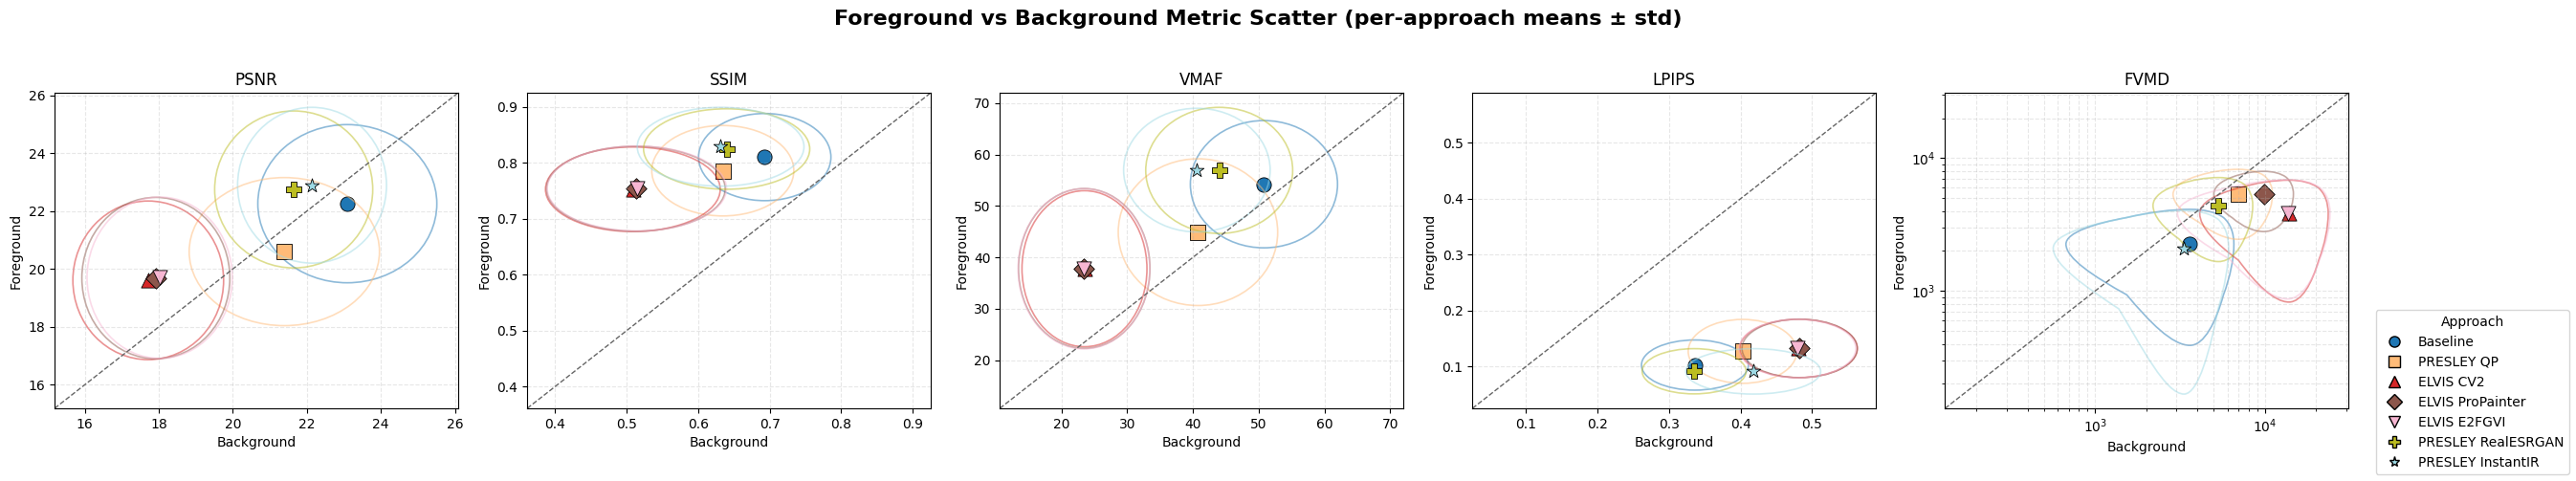

In [6]:
def _plot_metric_scatter(
    metric_points: Dict[str, List[Dict[str, Any]]],
    metrics: Sequence[str],
    approaches: Sequence[str],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    metrics_to_plot = [metric for metric in metrics if metric_points.get(metric)]
    if not metrics_to_plot:
        raise RuntimeError("No metrics with foreground/background pairs were found.")

    num_metrics = len(metrics_to_plot)
    cols = min(5, num_metrics)
    rows = math.ceil(num_metrics / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 5.0))
    axes_iter = list(axes.flat) if hasattr(axes, "flat") else [axes]

    unique_approaches = list(dict.fromkeys(approaches)) if approaches else ["default"]
    cmap = plt.get_cmap("tab20", max(1, len(unique_approaches)))
    marker_cycle = ["o", "s", "^", "D", "v", "P", "*", "X", "<", ">"]
    approach_styles = {
        approach: {
            "color": cmap(idx % cmap.N),
            "marker": marker_cycle[idx % len(marker_cycle)],
        }
        for idx, approach in enumerate(unique_approaches)
    }

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker=style["marker"],
            color="w",
            label=approach,
            markerfacecolor=style["color"],
            markeredgecolor="black",
            markersize=8,
        )
        for approach, style in approach_styles.items()
    ]

    point_size = 120

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes_iter[idx]
        points = metric_points[metric]
        metric_root = _metric_root(metric)
        use_log_scale = metric_root in LOG_SCALE_METRICS

        # Aggregate by approach: compute mean and std for foreground and background
        grouped: Dict[str, List[Tuple[float, float]]] = defaultdict(list)
        for point in points:
            try:
                fg_val = float(point["foreground"])
                bg_val = float(point["background"])
            except (TypeError, ValueError, KeyError):
                continue
            approach = point.get("approach") or point.get("experiment") or "default"
            grouped[approach].append((fg_val, bg_val))

        fg_means: List[float] = []
        bg_means: List[float] = []
        extent_values: List[float] = []

        for approach in unique_approaches:
            samples = grouped.get(approach, [])
            if not samples:
                continue
            fg_vals = [s[0] for s in samples if math.isfinite(s[0])]
            bg_vals = [s[1] for s in samples if math.isfinite(s[1])]
            if not fg_vals or not bg_vals:
                continue
            fg_mean = float(statistics.fmean(fg_vals))
            bg_mean = float(statistics.fmean(bg_vals))
            fg_std = float(statistics.pstdev(fg_vals)) if len(fg_vals) > 1 else 0.0
            bg_std = float(statistics.pstdev(bg_vals)) if len(bg_vals) > 1 else 0.0

            fg_plot = max(fg_mean, MIN_LOG_VALUE) if use_log_scale else fg_mean
            bg_plot = max(bg_mean, MIN_LOG_VALUE) if use_log_scale else bg_mean

            style = approach_styles.get(approach, {"color": "#999999", "marker": "o"})
            point_color = style["color"]

            # main dot (no transparency)
            ax.scatter(
                [bg_plot],
                [fg_plot],
                color=point_color,
                alpha=1.0,
                marker=style["marker"],
                edgecolor="black",
                linewidth=0.6,
                s=point_size,
            )

            # circle/ellipse representing std
            if fg_std > 0 or bg_std > 0:
                ellipse = Ellipse(
                    xy=(bg_plot, fg_plot),
                    width=max(1e-6, 2 * (bg_std if not use_log_scale else max(bg_std, MIN_LOG_VALUE))),
                    height=max(1e-6, 2 * (fg_std if not use_log_scale else max(fg_std, MIN_LOG_VALUE))),
                    edgecolor=point_color,
                    facecolor="none",
                    linewidth=1.2,
                    alpha=0.5,
                )
                ax.add_patch(ellipse)
                candidate_values = [
                    fg_plot + fg_std,
                    fg_plot - fg_std,
                    bg_plot + bg_std,
                    bg_plot - bg_std,
                ]
                if use_log_scale:
                    for candidate in candidate_values:
                        if math.isfinite(candidate):
                            extent_values.append(max(candidate, MIN_LOG_VALUE))
                else:
                    extent_values.extend([candidate for candidate in candidate_values if math.isfinite(candidate)])

            fg_means.append(fg_plot)
            bg_means.append(bg_plot)

        combined = fg_means + bg_means + extent_values
        finite_values = [val for val in combined if math.isfinite(val)]
        if use_log_scale:
            finite_values = [val for val in finite_values if val > 0]

        line_lower = None
        line_upper = None
        if finite_values:
            min_val = min(finite_values)
            max_val = max(finite_values)
            if use_log_scale:
                log_min = math.log10(min_val)
                log_max = math.log10(max_val)
                if math.isclose(log_min, log_max):
                    delta = 0.5
                else:
                    delta = (log_max - log_min) * 0.05
                lower = 10 ** (log_min - delta)
                upper = 10 ** (log_max + delta)
                lower = max(lower, MIN_LOG_VALUE)
                ax.set_xscale("log")
                ax.set_yscale("log")
            else:
                span = max_val - min_val
                padding = 1.0 if span < 1e-6 else span * 0.05
                lower = min_val - padding
                upper = max_val + padding
            if upper <= lower:
                if use_log_scale:
                    upper = lower * 1.1
                else:
                    upper = lower + 1.0
            ax.set_xlim(lower, upper)
            ax.set_ylim(lower, upper)
            line_lower, line_upper = lower, upper
        elif use_log_scale:
            ax.set_xscale("log")
            ax.set_yscale("log")

        if line_lower is not None and line_upper is not None:
            ax.plot([line_lower, line_upper], [line_lower, line_upper], linestyle="--", color="#666666", linewidth=1.0)

        title = metric.replace("_mean", "").replace("_", " ").upper()
        ax.set_title(title)
        ax.set_xlabel("Background")
        ax.set_ylabel("Foreground")
        grid_kwargs = {"linestyle": "--", "alpha": 0.3}
        if use_log_scale:
            ax.grid(True, which="both", **grid_kwargs)
        else:
            ax.grid(True, **grid_kwargs)

    for ax in axes_iter[num_metrics:]:
        ax.axis("off")

    if legend_elements:
        fig.legend(legend_elements, [elem.get_label() for elem in legend_elements], loc="lower right", title="Approach")
    fig.suptitle("Foreground vs Background Metric Scatter (per-approach means ± std)", fontsize=16, fontweight="bold")
    fig.tight_layout(rect=(0.02, 0.02, 0.92, 0.95))

#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi)
#     print(f"Saved scatter plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)

    point_size = 120

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes_iter[idx]
        points = metric_points[metric]
        metric_root = _metric_root(metric)
        use_log_scale = metric_root in LOG_SCALE_METRICS

        # Aggregate by approach: compute mean and std for foreground and background
        grouped: Dict[str, List[Tuple[float, float]]] = defaultdict(list)
        for point in points:
            try:
                fg_val = float(point["foreground"])
                bg_val = float(point["background"])
            except (TypeError, ValueError, KeyError):
                continue
            approach = point.get("approach") or point.get("experiment") or "default"
            grouped[approach].append((fg_val, bg_val))

        fg_means: List[float] = []
        bg_means: List[float] = []
        extent_values: List[float] = []

        for approach in unique_approaches:
            samples = grouped.get(approach, [])
            if not samples:
                continue
            fg_vals = [s[0] for s in samples if math.isfinite(s[0])]
            bg_vals = [s[1] for s in samples if math.isfinite(s[1])]
            if not fg_vals or not bg_vals:
                continue
            fg_mean = float(statistics.fmean(fg_vals))
            bg_mean = float(statistics.fmean(bg_vals))
            fg_std = float(statistics.pstdev(fg_vals)) if len(fg_vals) > 1 else 0.0
            bg_std = float(statistics.pstdev(bg_vals)) if len(bg_vals) > 1 else 0.0

            fg_plot = max(fg_mean, MIN_LOG_VALUE) if use_log_scale else fg_mean
            bg_plot = max(bg_mean, MIN_LOG_VALUE) if use_log_scale else bg_mean

            style = approach_styles.get(approach, {"color": "#999999", "marker": "o"})
            point_color = style["color"]

            # main dot
            # main dot (no transparency)
            ax.scatter(
                [bg_plot],
                [fg_plot],
                color=point_color,
                alpha=1.0,
                marker=style["marker"],
                edgecolor="black",
                linewidth=0.6,
                s=point_size,
            )

            # circle/ellipse representing std
            if fg_std > 0 or bg_std > 0:
                ellipse = Ellipse(
                    xy=(bg_plot, fg_plot),
                    width=max(1e-6, 2 * (bg_std if not use_log_scale else max(bg_std, MIN_LOG_VALUE))),
                    height=max(1e-6, 2 * (fg_std if not use_log_scale else max(fg_std, MIN_LOG_VALUE))),
                    edgecolor=point_color,
                    facecolor="none",
                    linewidth=1.2,
                    alpha=0.5,
                )
                ax.add_patch(ellipse)
                candidate_values = [
                    fg_plot + fg_std,
                    fg_plot - fg_std,
                    bg_plot + bg_std,
                    bg_plot - bg_std,
                ]
                if use_log_scale:
                    for candidate in candidate_values:
                        if math.isfinite(candidate):
                            extent_values.append(max(candidate, MIN_LOG_VALUE))
                else:
                    extent_values.extend([candidate for candidate in candidate_values if math.isfinite(candidate)])

            fg_means.append(fg_plot)
            bg_means.append(bg_plot)

        combined = fg_means + bg_means + extent_values
        finite_values = [val for val in combined if math.isfinite(val)]
        if use_log_scale:
            finite_values = [val for val in finite_values if val > 0]

        line_lower = None
        line_upper = None
        if finite_values:
            min_val = min(finite_values)
            max_val = max(finite_values)
            if use_log_scale:
                log_min = math.log10(min_val)
                log_max = math.log10(max_val)
                if math.isclose(log_min, log_max):
                    delta = 0.5
                else:
                    delta = (log_max - log_min) * 0.05
                lower = 10 ** (log_min - delta)
                upper = 10 ** (log_max + delta)
                lower = max(lower, MIN_LOG_VALUE)
                ax.set_xscale("log")
                ax.set_yscale("log")
            else:
                span = max_val - min_val
                padding = 1.0 if span < 1e-6 else span * 0.05
                lower = min_val - padding
                upper = max_val + padding
            if upper <= lower:
                if use_log_scale:
                    upper = lower * 1.1
                else:
                    upper = lower + 1.0
            ax.set_xlim(lower, upper)
            ax.set_ylim(lower, upper)
            line_lower, line_upper = lower, upper
        elif use_log_scale:
            ax.set_xscale("log")
            ax.set_yscale("log")

        if line_lower is not None and line_upper is not None:
            ax.plot([line_lower, line_upper], [line_lower, line_upper], linestyle="--", color="#666666", linewidth=1.0)

        title = metric.replace("_mean", "").replace("_", " ").upper()
        ax.set_title(title)
        ax.set_xlabel("Background")
        ax.set_ylabel("Foreground")
        grid_kwargs = {"linestyle": "--", "alpha": 0.3}
        if use_log_scale:
            ax.grid(True, which="both", **grid_kwargs)
        else:
            ax.grid(True, **grid_kwargs)

    for ax in axes_iter[num_metrics:]:
        ax.axis("off")

    if legend_elements:
        fig.legend(legend_elements, [elem.get_label() for elem in legend_elements], loc="lower right", title="Approach")
    fig.suptitle("Foreground vs Background Metric Scatter (per-approach means ± std)", fontsize=16, fontweight="bold")
    fig.tight_layout(rect=(0.02, 0.02, 0.92, 0.95))

#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi)
#     print(f"Saved scatter plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)



if 'metric_points' in locals() and metric_points:
    scatter_output = OUTPUT_DIR / "metric_scatter.png"
    _plot_metric_scatter(metric_points, metrics, approaches, scatter_output, DPI, SHOW_PLOT)


## Metric Violin Plot

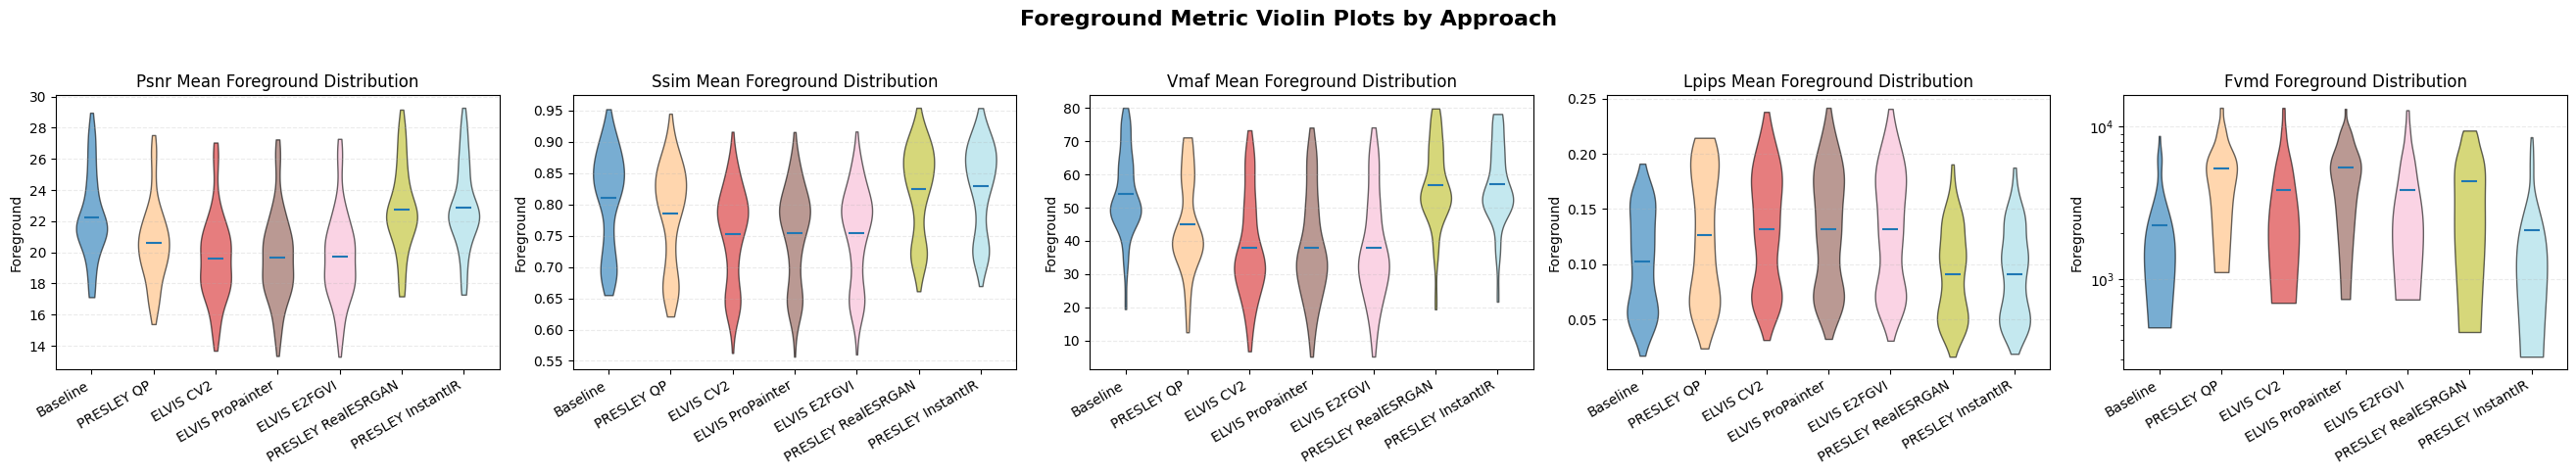

In [7]:
def _plot_metric_violin_foreground(
    metric_points: Dict[str, List[Dict[str, Any]]],
    metrics: Sequence[str],
    approaches: Sequence[str],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    metrics_to_plot = [metric for metric in metrics if metric_points.get(metric)]
    if not metrics_to_plot:
        print("No metric data available for foreground violin plot; skipping.")
        return

    # place up to 5 subplots on the first row for consistency with other figures
    cols = min(5, len(metrics_to_plot))
    rows = math.ceil(len(metrics_to_plot) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 5.0))
    axes_iter = np.atleast_1d(axes).ravel()
    unique_approaches = list(dict.fromkeys(approaches)) if approaches else ["default"]
    cmap = plt.get_cmap("tab20", max(1, len(unique_approaches)))
    approach_colors = {approach: cmap(idx % cmap.N) for idx, approach in enumerate(unique_approaches)}

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes_iter[idx]
        entries = metric_points.get(metric, [])
        distributions: List[np.ndarray] = []
        labels: List[str] = []
        colors: List[Any] = []

        for approach in unique_approaches:
            filtered = [entry for entry in entries if entry.get("approach") == approach]
            if not filtered and approach == "default":
                filtered = entries
            _, foregrounds = _extract_foreground_background_arrays(filtered)
            # keep only finite values so violin can be created even when some NaNs exist
            finite_fg = foregrounds[np.isfinite(foregrounds)]
            if finite_fg.size == 0:
                # still skip approaches with no finite samples
                continue
            distributions.append(finite_fg)
            labels.append(approach)
            colors.append(approach_colors.get(approach, "#888888"))

        if not distributions:
            ax.set_visible(False)
            continue

        parts = ax.violinplot(distributions, showmeans=True, showextrema=False)
        for body, color in zip(parts["bodies"], colors):
            body.set_facecolor(color)
            body.set_edgecolor("black")
            body.set_alpha(0.6)

        ax.set_xticks(range(1, len(labels) + 1))
        ax.set_xticklabels(labels, rotation=30, ha="right")
        ax.set_ylabel("Foreground")
        ax.set_title(f"{metric.replace('_', ' ').title()} Foreground Distribution")
        if metric in LOG_SCALE_METRICS:
            ax.set_yscale("log")
        ax.grid(True, axis="y", linestyle="--", alpha=0.25)

    for ax in axes_iter[len(metrics_to_plot) :]:
        ax.remove()

    fig.suptitle("Foreground Metric Violin Plots by Approach", fontsize=16, fontweight="bold")
    fig.tight_layout(rect=(0.02, 0.02, 0.98, 0.95))

#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi)
#     print(f"Saved foreground violin plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)



if 'metric_points' in locals() and metric_points:
    violin_output = OUTPUT_DIR / METRIC_VIOLIN_FIGURE_NAME
    _plot_metric_violin_foreground(metric_points, metrics, approaches, violin_output, DPI, SHOW_PLOT)


## Metric Box Plot

/tmp/ipykernel_2983918/4151849607.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(distributions, labels=labels, showmeans=True)
/tmp/ipykernel_2983918/4151849607.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(distributions, labels=labels, showmeans=True)
/tmp/ipykernel_2983918/4151849607.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(distributions, labels=labels, showmeans=True)
/tmp/ipykernel_2983918/4151849607.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be 

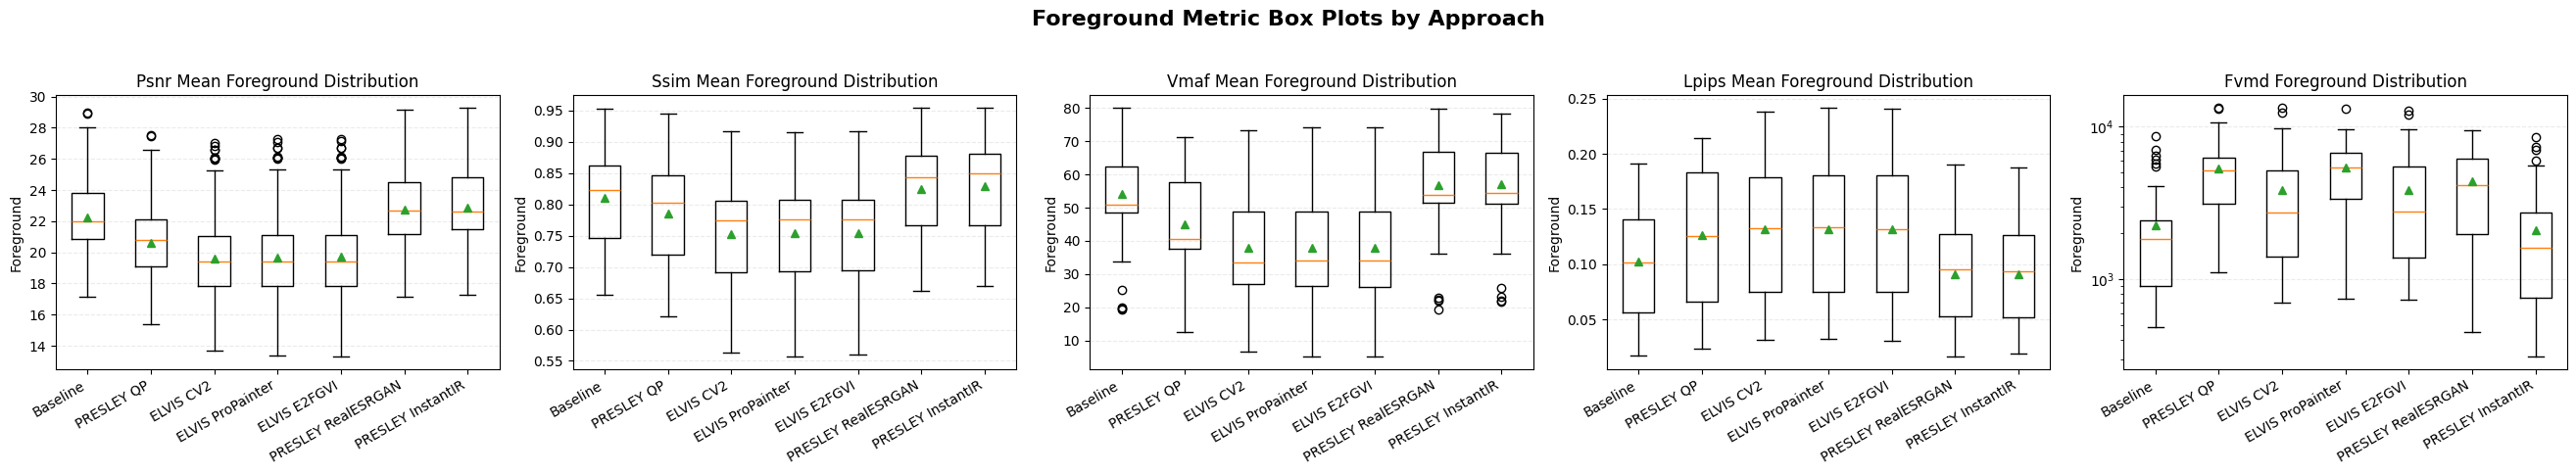

In [8]:
def _plot_metric_box_foreground(
    metric_points: Dict[str, List[Dict[str, Any]]],
    metrics: Sequence[str],
    approaches: Sequence[str],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    metrics_to_plot = [metric for metric in metrics if metric_points.get(metric)]
    if not metrics_to_plot:
        print("No metric data available for foreground box plot; skipping.")
        return

    cols = min(5, len(metrics_to_plot))
    rows = math.ceil(len(metrics_to_plot) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 5.0))
    axes_iter = np.atleast_1d(axes).ravel()
    unique_approaches = list(dict.fromkeys(approaches)) if approaches else ["default"]

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes_iter[idx]
        entries = metric_points.get(metric, [])
        distributions: List[np.ndarray] = []
        labels: List[str] = []

        for approach in unique_approaches:
            filtered = [entry for entry in entries if entry.get("approach") == approach]
            if not filtered and approach == "default":
                filtered = entries
            _, foregrounds = _extract_foreground_background_arrays(filtered)
            finite_fg = foregrounds[np.isfinite(foregrounds)]
            if finite_fg.size == 0:
                continue
            distributions.append(finite_fg)
            labels.append(approach)

        if not distributions:
            ax.set_visible(False)
            continue

        ax.boxplot(distributions, labels=labels, showmeans=True)
        ax.set_xticklabels(labels, rotation=30, ha="right")
        ax.set_ylabel("Foreground")
        ax.set_title(f"{metric.replace('_', ' ').title()} Foreground Distribution")
        if metric in LOG_SCALE_METRICS:
            ax.set_yscale("log")
        ax.grid(True, axis="y", linestyle="--", alpha=0.25)

    for ax in axes_iter[len(metrics_to_plot) :]:
        ax.remove()

    fig.suptitle("Foreground Metric Box Plots by Approach", fontsize=16, fontweight="bold")
    fig.tight_layout(rect=(0.02, 0.02, 0.98, 0.95))

    if show_plot:
        plt.show()
    else:
        plt.close(fig)

if 'metric_points' in locals() and metric_points:
    box_output = OUTPUT_DIR / "metric_box_plot.png"
    _plot_metric_box_foreground(metric_points, metrics, approaches, box_output, DPI, SHOW_PLOT)


## Metric Offset Heatmap

Using 'Baseline' as baseline for offset calculations.


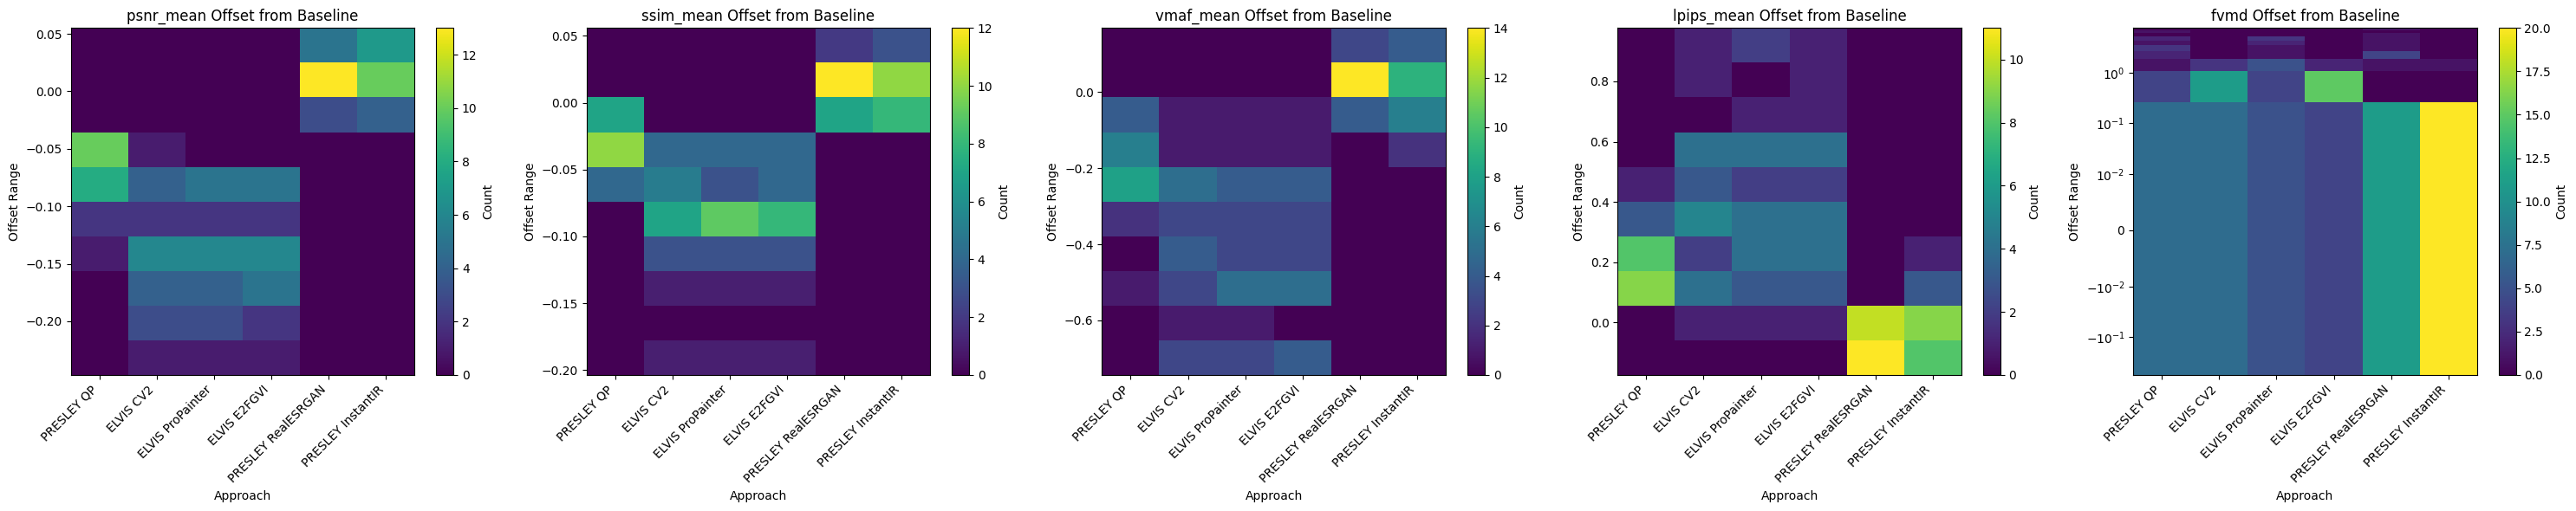

In [9]:
def _plot_metric_offset_heatmap(
    metric_points: Dict[str, List[Dict[str, Any]]],
    metrics: Sequence[str],
    approaches: Sequence[str],
    output_path: Path,
    dpi: int,
    show_plot: bool,
    n_bins: int = 10,
) -> None:
    metrics_to_plot = [metric for metric in metrics if metric_points.get(metric)]
    if not metrics_to_plot:
        print("No metric data available for offset heatmap; skipping.")
        return

    unique_approaches = list(dict.fromkeys(approaches))
    baseline_candidates = [a for a in unique_approaches if "baseline" in a.lower()]
    if not baseline_candidates:
        baseline_candidates = [a for a in unique_approaches if "avc" in a.lower() or "hevc" in a.lower()]
    
    if not baseline_candidates:
        print("No baseline approach found (looked for 'baseline', 'avc', 'hevc'). Skipping offset heatmap.")
        return
    
    baseline_name = baseline_candidates[0]
    print(f"Using '{baseline_name}' as baseline for offset calculations.")

    # Single row layout
    cols = len(metrics_to_plot)
    rows = 1
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6.0, 6.0))
    axes_iter = np.atleast_1d(axes).ravel()

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes_iter[idx]
        entries = metric_points.get(metric, [])
        
        video_map = defaultdict(dict)
        for entry in entries:
            vid = entry.get("video_name") or entry.get("label") or "unknown"
            app = entry.get("approach") or "default"
            fg = entry.get("foreground")
            if fg is not None and math.isfinite(float(fg)):
                video_map[vid][app] = float(fg)
        
        offsets = defaultdict(list)
        all_offsets = []
        
        for vid, app_vals in video_map.items():
            if baseline_name not in app_vals:
                continue
            base_val = app_vals[baseline_name]
            if base_val == 0:
                continue
                
            for app, val in app_vals.items():
                if app == baseline_name:
                    continue
                offset = (val - base_val) / base_val
                offsets[app].append(offset)
                all_offsets.append(offset)
        
        if not offsets or not all_offsets:
            ax.set_visible(False)
            continue
            
        # Create bins based on offset range
        min_offset = min(all_offsets)
        max_offset = max(all_offsets)
        bins = np.linspace(min_offset, max_offset, n_bins + 1)
             
        sorted_approaches = [a for a in unique_approaches if a in offsets]
        heatmap_data = np.zeros((len(bins)-1, len(sorted_approaches)))
        
        for col_idx, app in enumerate(sorted_approaches):
            vals = offsets[app]
            hist, _ = np.histogram(vals, bins=bins)
            heatmap_data[:, col_idx] = hist
            
        # Use pcolormesh to handle potentially non-uniform bins and allow log scaling
        X, Y = np.meshgrid(np.arange(len(sorted_approaches) + 1), bins)
        im = ax.pcolormesh(X, Y, heatmap_data, cmap='viridis', shading='flat')
        
        ax.set_xticks(np.arange(len(sorted_approaches)) + 0.5)
        ax.set_xticklabels(sorted_approaches, rotation=45, ha='right')
        ax.set_title(f"{metric} Offset from {baseline_name}")
        ax.set_xlabel("Approach")
        ax.set_ylabel("Offset Range")
        
        if "fvmd" in metric.lower():
             ax.set_yscale("symlog", linthresh=0.01)
             
        plt.colorbar(im, ax=ax, label="Count")

    for ax in axes_iter[len(metrics_to_plot) :]:
        ax.remove()

    fig.tight_layout()
    if show_plot:
        plt.show()
    else:
        plt.close(fig)

if 'metric_points' in locals() and metric_points:
    heatmap_output = OUTPUT_DIR / "metric_offset_heatmap.png"
    _plot_metric_offset_heatmap(metric_points, metrics, approaches, heatmap_output, DPI, SHOW_PLOT)


## Metric Stacked Bar Plot

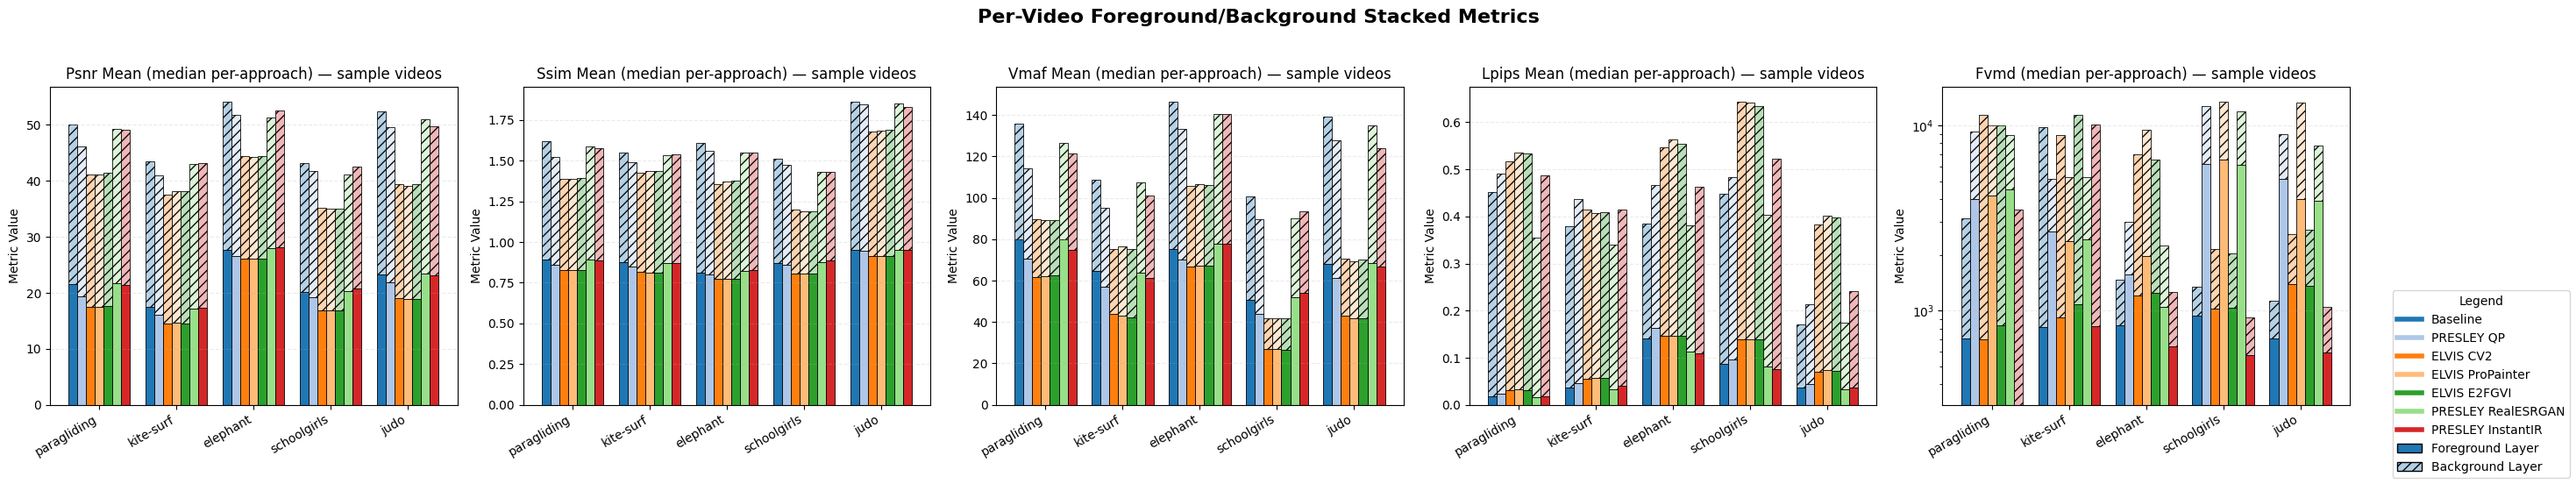

In [10]:
def _plot_metric_stacked_bar(
    metric_points: Dict[str, List[Dict[str, Any]]],
    metrics: Sequence[str],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    metrics_to_plot = [metric for metric in metrics if metric_points.get(metric)]
    if not metrics_to_plot:
        print("No metric data available for stacked bar plot; skipping.")
        return

    max_titles = 5

    def _normalize_video_label(raw_value: Any) -> str:
        text = str(raw_value or "unknown")
        try:
            text = text.split("/")[-1]
        except Exception:
            pass
        if "." in text:
            text = text.rsplit(".", 1)[0]
        return _shorten_video_name(text)

    def _select_fvmd_videos(limit: int) -> List[str]:
        entries = metric_points.get("fvmd") or []
        video_fg: Dict[str, List[float]] = defaultdict(list)
        all_videos: List[str] = []
        for entry in entries:
            video = _normalize_video_label(entry.get("video_name") or entry.get("label"))
            all_videos.append(video)
            try:
                fg_val = float(entry.get("foreground"))
            except (TypeError, ValueError):
                continue
            if not math.isfinite(fg_val) or fg_val <= 0.0:
                continue
            video_fg[video].append(fg_val)

        # Filter videos with at least one non-zero fvmd value and compute median
        video_medians = []
        for video, values in video_fg.items():
            if values:
                median_val = statistics.median(values)
                if median_val > 0.0:
                    video_medians.append((median_val, video))
        
        # Sort by lowest median first
        ranked = sorted(video_medians, key=lambda item: item[0])
        ordered = [video for _, video in ranked[:limit]]

        if len(ordered) < limit:
            seen = set(ordered)
            for video in all_videos:
                if video not in seen:
                    ordered.append(video)
                    seen.add(video)
                if len(ordered) >= limit:
                    break

        return ordered

    target_videos = _select_fvmd_videos(max_titles)

    cols = min(5, len(metrics_to_plot))
    rows = math.ceil(len(metrics_to_plot) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6.0, rows * 5.5))
    axes_iter = np.atleast_1d(axes).ravel()

    cmap = plt.get_cmap("tab20")
    approach_colors: Dict[str, Tuple[float, float, float]] = {}
    approach_handles: Dict[str, Line2D] = {}
    color_index = 0

    def get_approach_color(name: str) -> Tuple[float, float, float]:
        nonlocal color_index
        if name not in approach_colors:
            approach_colors[name] = tuple(to_rgb(cmap(color_index % cmap.N)))
            color_index += 1
        return approach_colors[name]

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes_iter[idx]
        entries = metric_points.get(metric, [])

        video_approach_map: Dict[str, Dict[str, Dict[str, List[float]]]] = defaultdict(lambda: defaultdict(lambda: {"foreground": [], "background": []}))
        all_approaches: List[str] = []

        for entry in entries:
            video_name = _normalize_video_label(entry.get("video_name") or entry.get("label"))
            approach = entry.get("approach") or entry.get("experiment") or "default"
            if approach not in all_approaches:
                all_approaches.append(approach)

            fg = entry.get("foreground")
            bg = entry.get("background")
            try:
                if fg is not None:
                    video_approach_map[video_name][approach]["foreground"].append(float(fg))
                if bg is not None:
                    video_approach_map[video_name][approach]["background"].append(float(bg))
            except (TypeError, ValueError):
                continue

        if not video_approach_map:
            ax.set_visible(False)
            continue

        aggregated_videos: List[Tuple[str, Dict[str, Tuple[float, float]]]] = []
        for video, apr_map in video_approach_map.items():
            stats: Dict[str, Tuple[float, float]] = {}
            for apr, vals in apr_map.items():
                # Filter out nan and inf values before computing median
                fg_clean = [v for v in vals["foreground"] if math.isfinite(v)]
                bg_clean = [v for v in vals["background"] if math.isfinite(v)]
                
                fg_median = statistics.median(fg_clean) if fg_clean else 0.0
                bg_median = statistics.median(bg_clean) if bg_clean else 0.0
                stats[apr] = (fg_median, bg_median)
            aggregated_videos.append((video, stats))

        aggregated_videos.sort(key=lambda item: statistics.median([vals[0] for vals in item[1].values()]) if item[1] else float("inf"))
        aggregated_map = {video: stats for video, stats in aggregated_videos}

        selected_videos = [video for video in target_videos if video in aggregated_map][:max_titles]
        if len(selected_videos) < max_titles:
            for video, _ in aggregated_videos:
                if video not in selected_videos:
                    selected_videos.append(video)
                if len(selected_videos) >= min(max_titles, len(aggregated_videos)):
                    break
        if not selected_videos:
            selected_videos = [video for video, _ in aggregated_videos[:max_titles]]

        unique_approaches = all_approaches or ["default"]
        n_approaches = max(1, len(unique_approaches))
        group_width = 0.8
        bar_width = group_width / n_approaches
        base_indices = np.arange(len(selected_videos))

        for k, approach in enumerate(unique_approaches):
            fg_vals: List[float] = []
            bg_vals: List[float] = []
            for video in selected_videos:
                stats = aggregated_map.get(video, {})
                fg_mean, bg_mean = stats.get(approach, (0.0, 0.0)) if isinstance(stats, dict) else (0.0, 0.0)
                fg_vals.append(fg_mean)
                bg_vals.append(bg_mean)

            positions = base_indices - group_width / 2.0 + k * bar_width + bar_width / 2.0
            fg_arr = np.array(fg_vals)
            bg_arr = np.array(bg_vals)

            base_rgb = np.array(get_approach_color(approach))
            fg_color = tuple(base_rgb)
            bg_color = tuple(np.clip(base_rgb * 0.35 + 0.65, 0.0, 1.0))

            ax.bar(
                positions,
                fg_arr,
                width=bar_width,
                color=fg_color,
                edgecolor="black",
                linewidth=0.6,
            )
            ax.bar(
                positions,
                bg_arr,
                width=bar_width,
                bottom=fg_arr,
                color=bg_color,
                edgecolor="black",
                linewidth=0.6,
                hatch="///",
                alpha=0.95,
            )

            if approach not in approach_handles:
                approach_handles[approach] = Line2D([0], [0], color=fg_color, lw=4, label=approach)

        ax.set_xticks(base_indices)
        ax.set_xticklabels(selected_videos, rotation=30, ha="right")
        ax.set_ylabel("Metric Value")
        ax.set_title(f"{metric.replace('_', ' ').title()} (median per-approach) — sample videos")
        if metric in LOG_SCALE_METRICS:
            ax.set_yscale("log")
        ax.grid(True, axis="y", linestyle="--", alpha=0.25)

    for ax in axes_iter[len(metrics_to_plot) :]:
        ax.remove()

    legend_handles: List[Any] = []
    legend_labels: List[str] = []
    if approach_handles:
        legend_handles.extend(approach_handles.values())
        legend_labels.extend([handle.get_label() for handle in approach_handles.values()])

    if approach_colors:
        first_key = next(iter(approach_colors))
        sample_rgb = np.array(approach_colors[first_key])
        fg_patch = Patch(facecolor=tuple(sample_rgb), edgecolor="black", label="Foreground Layer")
        bg_patch = Patch(
            facecolor=tuple(np.clip(sample_rgb * 0.35 + 0.65, 0.0, 1.0)),
            edgecolor="black",
            hatch="///",
            label="Background Layer",
        )
        legend_handles.extend([fg_patch, bg_patch])
        legend_labels.extend([fg_patch.get_label(), bg_patch.get_label()])

    if legend_handles:
        fig.legend(legend_handles, legend_labels, loc="lower right", title="Legend")

    fig.suptitle("Per-Video Foreground/Background Stacked Metrics", fontsize=16, fontweight="bold")
    fig.tight_layout(rect=(0.02, 0.02, 0.92, 0.95))

#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi)
#     print(f"Saved stacked bar plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)



if 'metric_points' in locals() and metric_points:
    stacked_output = OUTPUT_DIR / METRIC_STACKED_BAR_FIGURE_NAME
    _plot_metric_stacked_bar(metric_points, metrics, stacked_output, DPI, SHOW_PLOT)


## Execution Throughput by Resolution

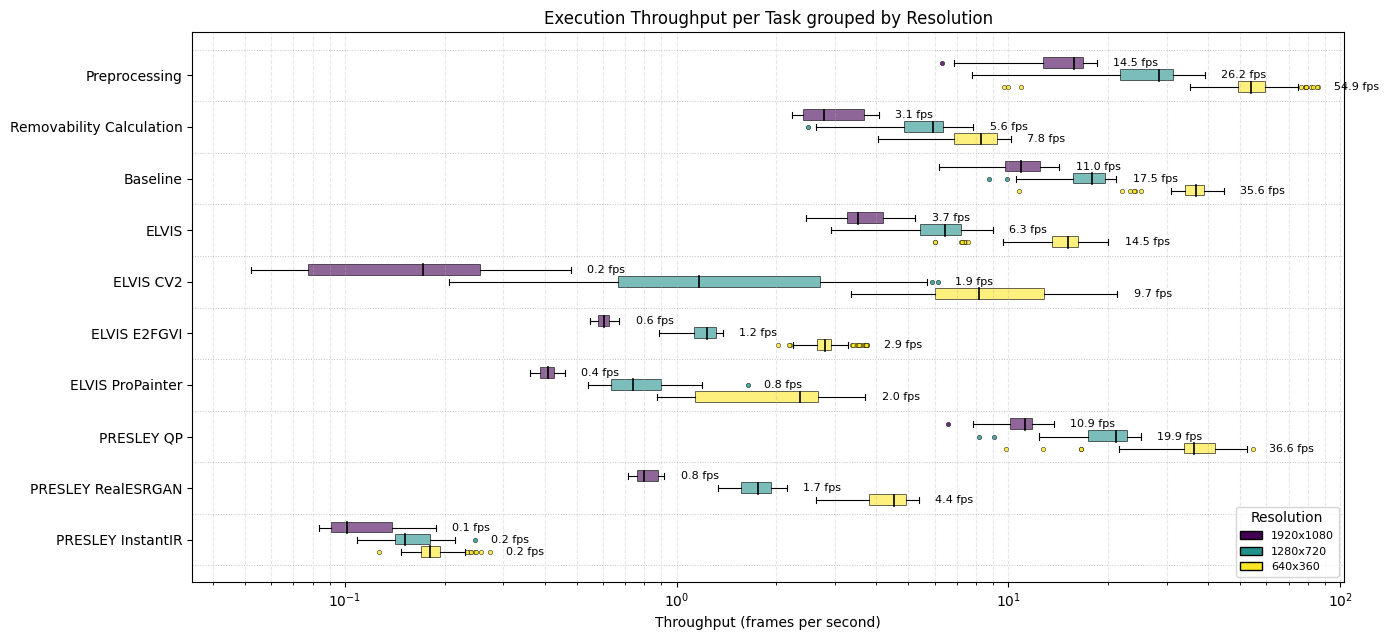

In [11]:
def _plot_execution_throughput_by_resolution(
    execution_throughput_by_res: Dict[str, Dict[str, List[float]]],
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    """Boxplot FPS per task grouped by resolution label."""
    if not execution_throughput_by_res:
        print("No resolution-grouped execution data available; skipping throughput-by-resolution plot.")
        return

    # Determine ordering of tasks by specified conceptual groups
    group_order = list(TASK_GROUP_ORDER)

    # Order tasks by (group, then by decreasing mean FPS within group)
    def task_sort_key(item: Tuple[str, Dict[str, List[float]]]) -> Tuple[int, float, str]:
        task, res_map = item
        group = _classify_task_group(task)
        try:
            gidx = group_order.index(group)
        except ValueError:
            gidx = len(group_order)
        all_samples = [s for samples in res_map.values() for s in samples if isinstance(s, (int, float)) and s > 0]
        mean_fps = statistics.fmean(all_samples) if all_samples else 0.0
        # negative mean to sort descending within group
        return (gidx, -mean_fps, task)

    ordered_tasks = [task for task, _ in sorted(execution_throughput_by_res.items(), key=task_sort_key)]
    if not ordered_tasks:
        print("No tasks available for resolution throughput plot; skipping.")
        return

    # Collect all resolution labels; order by decreasing pixel count if parseable
    resolutions = set()
    for res_map in execution_throughput_by_res.values():
        resolutions.update(res_map.keys())
    def _res_sort_key(label: str) -> Tuple[int, int, int]:
        try:
            if 'x' in label:
                w_str, h_str = label.lower().split('x')
                w = int(w_str)
                h = int(h_str)
                return (w*h, w, h)
        except Exception:
            pass
        return (0, 0, 0)
    ordered_res = sorted(resolutions, key=_res_sort_key, reverse=True)
    if "unknown" in ordered_res and len(ordered_res) > 1:
        # put unknown last
        ordered_res = [r for r in ordered_res if r != "unknown"] + ["unknown"]

    # Prepare data matrix: for each task, we have a list of per-resolution samples
    fig_height = max(5.0, 0.5 * len(ordered_tasks) + 1.5)
    fig_width = max(14.0, 3.0 + 1.6 * max(1, len(ordered_res)))
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Build grouped boxplots: each task has multiple resolutions side-by-side horizontally
    # We'll pivot to vertical stacking for readability: tasks on y-axis, resolutions as colored boxes per row.
    # Custom approach: draw individual boxplots manually per resolution offset.

    y_positions = np.arange(len(ordered_tasks))
    group_height = 0.7
    box_height = group_height / max(1, len(ordered_res))

    cmap = plt.get_cmap("viridis", len(ordered_res))
    res_colors = {res: cmap(i) for i, res in enumerate(ordered_res)}

    # Aggregate min/max to decide scale
    all_values: List[float] = []
    for task in ordered_tasks:
        res_map = execution_throughput_by_res.get(task, {})
        for res in ordered_res:
            samples = res_map.get(res, [])
            for s in samples:
                try:
                    v = float(s)
                except Exception:
                    continue
                if v > 0 and math.isfinite(v):
                    all_values.append(v)
    use_log = all_values and all(v > 0 for v in all_values)
    if use_log and all_values:
        min_val = min(all_values)
        max_val = max(all_values)
        if math.isclose(min_val, max_val):
            max_val = min_val * 1.2
    else:
        min_val = min(all_values) if all_values else 0.0
        max_val = max(all_values) if all_values else 1.0

    annotations: List[Tuple[float, float, str]] = []
    max_annotation_x: Optional[float] = None

    for task_index, task in enumerate(ordered_tasks):
        res_map = execution_throughput_by_res.get(task, {})
        base_y = y_positions[task_index]
        for r_index, res in enumerate(ordered_res):
            samples = [float(s) for s in res_map.get(res, []) if isinstance(s, (int, float)) and s > 0]
            if not samples:
                continue
            data = np.array(samples)
            # Boxplot stats
            q1 = np.percentile(data, 25)
            q2 = np.percentile(data, 50)
            q3 = np.percentile(data, 75)
            iqr = q3 - q1
            low_whisker = np.min(data[data >= q1 - 1.5 * iqr]) if data.size else q1
            high_whisker = np.max(data[data <= q3 + 1.5 * iqr]) if data.size else q3
            outliers = data[(data < low_whisker) | (data > high_whisker)]

            # Vertical positioning per resolution
            offset = -group_height / 2.0 + r_index * box_height + box_height / 2.0
            y_center = base_y + offset
            color = res_colors[res]

            # Draw box
            ax.add_patch(
                plt.Rectangle(
                    (q1, y_center - box_height / 2.0),
                    max(q3 - q1, 1e-9),
                    box_height * 0.9,
                    facecolor=color,
                    edgecolor="black",
                    linewidth=0.7,
                    alpha=0.6,
                )
            )
            # Median line
            ax.plot([q2, q2], [y_center - box_height * 0.45, y_center + box_height * 0.45], color="black", linewidth=1.2)
            # Whiskers
            ax.plot([low_whisker, q1], [y_center, y_center], color="black", linewidth=0.8)
            ax.plot([q3, high_whisker], [y_center, y_center], color="black", linewidth=0.8)
            ax.plot([low_whisker, low_whisker], [y_center - box_height * 0.25, y_center + box_height * 0.25], color="black", linewidth=0.8)
            ax.plot([high_whisker, high_whisker], [y_center - box_height * 0.25, y_center + box_height * 0.25], color="black", linewidth=0.8)
            # Outliers
            if outliers.size:
                ax.scatter(outliers, np.full(outliers.shape, y_center), s=10, color=color, edgecolors="black", linewidths=0.4, alpha=0.8)
            # Mean annotation positioned beyond whiskers/outliers
            mean_val = float(statistics.fmean(data)) if data.size else q2
            label = f"{mean_val:.1f} fps"
            high_extent = float(max(high_whisker, np.max(outliers) if outliers.size else high_whisker))
            if use_log:
                high_extent = max(high_extent, MIN_LOG_VALUE)
                text_x = high_extent * 1.12
            else:
                span_for_margin = max(max_val - min_val, 1e-6)
                margin = max(0.02 * span_for_margin, 0.1)
                text_x = high_extent + margin
            annotations.append((text_x, y_center, label))
            max_annotation_x = text_x if max_annotation_x is None else max(max_annotation_x, text_x)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(ordered_tasks)
    ax.invert_yaxis()
    ax.set_xlabel("Throughput (frames per second)")
    ax.set_title("Execution Throughput per Task grouped by Resolution")

    boundaries = np.arange(len(ordered_tasks) + 1) - 0.5
    for boundary in boundaries:
        ax.axhline(boundary, linestyle=":", linewidth=0.7, color="#999999", alpha=0.6, zorder=0)

    if use_log:
        ax.set_xscale("log")
        lower = max(min_val / 1.5, MIN_LOG_VALUE)
        upper = max(max_val * 1.2, lower * 1.5)
        if max_annotation_x is not None:
            upper = max(upper, max_annotation_x * 1.02)
        ax.set_xlim(lower, upper)
        ax.grid(True, axis="x", which="both", linestyle="--", alpha=0.3)
    else:
        if max_annotation_x is not None:
            max_val = max(max_val, max_annotation_x)
        span = max_val - min_val
        padding = 0.1 * span if span > 0 else max_val * 0.2 if max_val > 0 else 1.0
        left = max(0.0, min_val - padding * 0.5)
        ax.set_xlim(left, max_val + padding)
        ax.grid(True, axis="x", linestyle="--", alpha=0.3)

    for text_x, y_pos, label in annotations:
        ax.text(text_x, y_pos, label, va="center", ha="left", fontsize=8, color="black")

    # Legend for resolutions
    legend_handles = [
        Patch(facecolor=res_colors[res], edgecolor="black", label=res) for res in ordered_res
    ]
    ax.legend(handles=legend_handles, title="Resolution", loc="lower right", fontsize=8)

    fig.tight_layout()
#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi, bbox_inches="tight")
#     print(f"Saved execution throughput by resolution plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)



if 'execution_throughput_by_res' in locals() and execution_throughput_by_res:
    throughput_res_output = OUTPUT_DIR / TIME_COMPLEXITY_BY_RES_FIGURE_NAME
    _plot_execution_throughput_by_resolution(execution_throughput_by_res, throughput_res_output, DPI, SHOW_PLOT)
else:
    print("No resolution-grouped throughput data; skipping throughput-by-resolution figure.")


## ELVIS Parameter Correlation

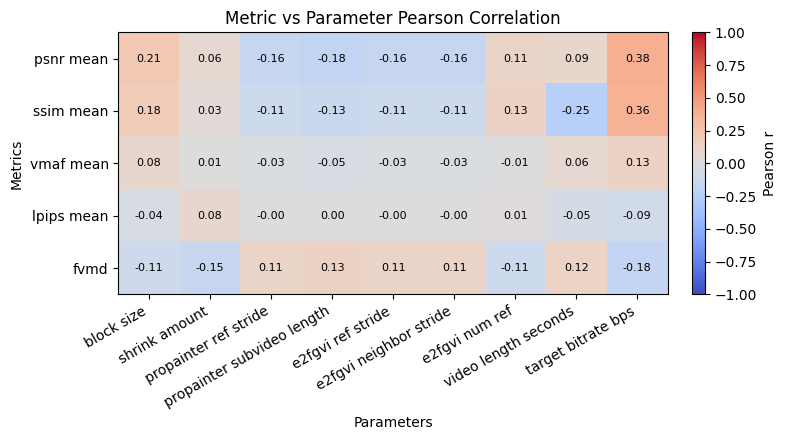

In [12]:
def _plot_parameter_correlation_from_matrices(
    param_keys: Sequence[str],
    metric_keys: Sequence[str],
    params_arr: np.ndarray,
    metrics_arr: np.ndarray,
    output_path: Path,
    dpi: int,
    show_plot: bool,
) -> None:
    """
    Compute Pearson correlation between each parameter and each metric using numeric matrices.
    """
    if params_arr.size == 0 or metrics_arr.size == 0:
        print("Empty parameter or metric matrices; skipping correlation plot.")
        return

    P = params_arr.shape[1]
    M = metrics_arr.shape[1]
    corr_matrix = np.full((P, M), np.nan, dtype=float)

    for i in range(P):
        for j in range(M):
            x = params_arr[:, i]
            y = metrics_arr[:, j]
            mask = np.isfinite(x) & np.isfinite(y)
            if np.count_nonzero(mask) < 2:
                continue
            xk = x[mask]
            yk = y[mask]
            if len(set(xk)) < 2 or len(set(yk)) < 2:
                continue
            try:
                r = float(np.corrcoef(xk, yk)[0, 1])
            except Exception:
                r = np.nan
            corr_matrix[i, j] = r

    valid_param_indices = [idx for idx in range(P) if not np.all(np.isnan(corr_matrix[idx, :]))]
    if not valid_param_indices:
        print("No parameter correlations to plot; skipping correlation plot.")
        return

    filtered_param_keys = [param_keys[idx] for idx in valid_param_indices]
    filtered_corr = corr_matrix[valid_param_indices, :]
    display_matrix = filtered_corr.T

    fig_width = max(8.0, 0.6 * len(filtered_param_keys))
    fig_height = max(4.5, 0.45 * M)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    im = ax.imshow(display_matrix, cmap="coolwarm", vmin=-1.0, vmax=1.0, aspect="auto")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Pearson r")

    ax.set_xticks(range(len(filtered_param_keys)))
    ax.set_xticklabels([pk.replace("_", " ") for pk in filtered_param_keys], rotation=30, ha="right")
    ax.set_yticks(range(len(metric_keys)))
    ax.set_yticklabels([m.replace("_", " ") for m in metric_keys])

    for i in range(len(metric_keys)):
        for j in range(len(filtered_param_keys)):
            val = filtered_corr[j, i]
            txt = "" if np.isnan(val) else f"{val:.2f}"
            ax.text(j, i, txt, ha="center", va="center", fontsize=8, color="black")

    ax.set_xlabel("Parameters")
    ax.set_ylabel("Metrics")
    ax.set_title("Metric vs Parameter Pearson Correlation")
    fig.tight_layout()

#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     fig.savefig(output_path, dpi=dpi, bbox_inches="tight")
#     print(f"Saved parameter vs metric correlation plot to {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)



if 'param_keys' in locals():
    elvis_keys, elvis_params = _select_param_subset(param_keys, params_arr, group="elvis")
    if elvis_keys:
        elvis_output = OUTPUT_DIR / PARAM_CORRELATION_ELVIS_FIGURE_NAME
        _plot_parameter_correlation_from_matrices(elvis_keys, metric_keys, elvis_params, metrics_arr, elvis_output, DPI, SHOW_PLOT)
    else:
        print("No ELVIS parameters available for correlation plot; skipping.")


## PRESLEY Parameter Correlation

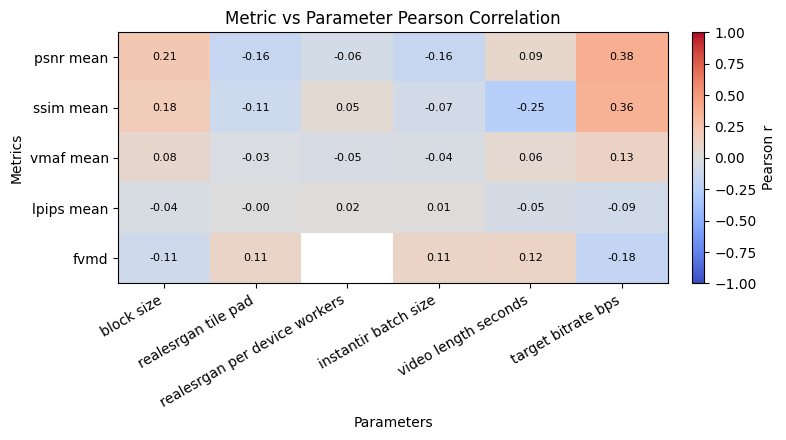

In [13]:
if 'param_keys' in locals():
    presley_keys, presley_params = _select_param_subset(param_keys, params_arr, group="presley")
    if presley_keys:
        presley_output = OUTPUT_DIR / PARAM_CORRELATION_PRESLEY_FIGURE_NAME
        _plot_parameter_correlation_from_matrices(presley_keys, metric_keys, presley_params, metrics_arr, presley_output, DPI, SHOW_PLOT)
    else:
        print("No PRESLEY parameters available for correlation plot; skipping.")
